# 라이브러리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !set -x \
# && pip install konlpy \
# && curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x
!pip install soynlp
!pip install wordcloud
!pip install pyLDAvis==2.1.2
!pip install pmdarima

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 12, 12   # 그래프 크기
plt.rcParams['axes.unicode_minus'] = False   # 음수에서 폰트 깨지는거 방지

%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
fontpath = r"/content/drive/MyDrive/3조_final_project/98_코딩파일/NanumBarunGothic.ttf"
font = fm.FontProperties(fname=fontpath, size=14)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [4]:
import numpy as np
import pandas as pd

from wordcloud import WordCloud
from IPython.display import Image

from collections import Counter

# 경고문 무시
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
from nltk import word_tokenize, bigrams, ConditionalFreqDist
from nltk.util import ngrams
from nltk.probability import ConditionalProbDist, MLEProbDist
# from konlpy.tag import Okt, Hannanum, Kkma, Komoran, Mecab
import soynlp
from soynlp.noun import LRNounExtractor_v2
from soynlp.tokenizer import LTokenizer

from gensim import corpora
from gensim.models import LsiModel, LdaModel, Word2Vec
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# 파일 합치기
import glob
import sys
import os

# 기타
import re
import requests
import json
import time
from google.colab import drive
from tqdm import notebook

# 0 전처리

## 데이터 로드
- https://entertain.naver.com/now?date=2021-12-01&page=1#sid=106&date=2021-12-31&page=205

In [5]:
df = pd.read_csv(r'/content/drive/MyDrive/3조_final_project/02_연예 뉴스/news_soynlp.csv')

In [6]:
df.head()

,날짜,제목,soynlp_nouns
0,2021-10-01,송가인 트롯스타 주 연속 압도적 위 대체불가 존재감 입증,"['송가', '인', '트롯스타', '주', '연속', '압도적', '위', '대체..."
1,2021-10-01,원 더 우먼 이하늬 이상윤 괴한 등장에 카리스마 방어 액션 현장 포착,"['원', '더', '우먼', '이하늬', '이상윤', '괴한', '등장', '에'..."
2,2021-10-01,신다은 임성빈 도움 받아 새집 리모델링 구상 뚝딱 남편 잘 뒀네,"['신다은', '임성빈', '도움', '받아', '새집', '리모델링', '구상',..."
3,2021-10-01,금쪽같은 내새끼 외상 후 스트레스 장애로 고통받는 딸 특별판 구성,"['금쪽', '같은', '내새끼', '외상', '후', '스트레', '스', '장애..."
4,2021-10-01,김나영 얼마나 말랐으면 비현실적 학다리,"['김나영', '얼마나', '말랐으면', '비현실적', '학다리']"


In [7]:
# 컬럼명 변경
df.columns = ['일자', '제목', 'soynlp_noun']

# 일자 데이터 타입 변경
df['일자']=pd.to_datetime(df['일자'], errors='coerce', format='%Y-%m-%d')

In [8]:
df.groupby('일자').count()

,제목,soynlp_noun
일자,,
2021-10-01,4125,4125
2021-10-02,2925,2925
2021-10-03,1950,1950
2021-10-04,2350,2350
2021-10-05,4550,4550
...,...,...
2021-12-27,3606,3606
2021-12-28,4229,4229
2021-12-29,4316,4316


In [9]:
# 달 분리
df.insert(loc=1,column='month',value=df['일자'].dt.month)

print(len(df.일자.unique()))
print(len(df.month.unique()))

92
3


In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
df.head()

,일자,month,제목,soynlp_noun
0,2021-10-01,10,송가인 트롯스타 주 연속 압도적 위 대체불가 존재감 입증,"['송가', '인', '트롯스타', '주', '연속', '압도적', '위', '대체..."
1,2021-10-01,10,원 더 우먼 이하늬 이상윤 괴한 등장에 카리스마 방어 액션 현장 포착,"['원', '더', '우먼', '이하늬', '이상윤', '괴한', '등장', '에'..."
2,2021-10-01,10,신다은 임성빈 도움 받아 새집 리모델링 구상 뚝딱 남편 잘 뒀네,"['신다은', '임성빈', '도움', '받아', '새집', '리모델링', '구상',..."
3,2021-10-01,10,금쪽같은 내새끼 외상 후 스트레스 장애로 고통받는 딸 특별판 구성,"['금쪽', '같은', '내새끼', '외상', '후', '스트레', '스', '장애..."
4,2021-10-01,10,김나영 얼마나 말랐으면 비현실적 학다리,"['김나영', '얼마나', '말랐으면', '비현실적', '학다리']"


In [12]:
df.isna().sum()

일자             0
month          0
제목             0
soynlp_noun    0
dtype: int64

In [13]:
df.shape

(354813, 4)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354813 entries, 0 to 354812
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   일자           354813 non-null  datetime64[ns]
 1   month        354813 non-null  int64         
 2   제목           354813 non-null  object        
 3   soynlp_noun  354813 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 10.8+ MB


## 단어 추출 (soynlp)
- https://github.com/lovit/soynlp

In [15]:
df['제목'] = df['제목'].str.replace("[^a-zA-Zㄱ-ㅣ가-힣 ]"," ")

In [16]:
# 형태소 분석기
noun_extractor = LRNounExtractor_v2()
nouns = noun_extractor.train_extract(list(df['제목']))
noun_scores = {noun:score.score for noun, score in nouns.items()}
tokenizer = LTokenizer(scores=noun_scores)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 174842 from 354813 sents. mem=0.478 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=2767262, mem=0.714 Gb
[Noun Extractor] batch prediction was completed for 38955 words
[Noun Extractor] checked compounds. discovered 13980 compounds
[Noun Extractor] postprocessing detaching_features : 30613 -> 27235
[Noun Extractor] postprocessing ignore_features : 27235 -> 27098
[Noun Extractor] postprocessing ignore_NJ : 27098 -> 26972
[Noun Extractor] 26972 nouns (13980 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=0.753 Gb                    
[Noun Extractor] 75.94 % eojeols are covered


In [17]:
df['soynlp_noun'] = df['제목'].apply(lambda x : tokenizer.tokenize(x))

In [18]:
df.head()

,일자,month,제목,soynlp_noun
0,2021-10-01,10,송가인 트롯스타 주 연속 압도적 위 대체불가 존재감 입증,"[송가, 인, 트롯스타, 주, 연속, 압도적, 위, 대체불가, 존재감, 입증]"
1,2021-10-01,10,원 더 우먼 이하늬 이상윤 괴한 등장에 카리스마 방어 액션 현장 포착,"[원, 더, 우먼, 이하늬, 이상윤, 괴한, 등장, 에, 카리스마, 방어, 액션, ..."
2,2021-10-01,10,신다은 임성빈 도움 받아 새집 리모델링 구상 뚝딱 남편 잘 뒀네,"[신다은, 임성빈, 도움, 받아, 새집, 리모델링, 구상, 뚝딱, 남편, 잘, 뒀네]"
3,2021-10-01,10,금쪽같은 내새끼 외상 후 스트레스 장애로 고통받는 딸 특별판 구성,"[금쪽, 같은, 내새끼, 외상, 후, 스트레, 스, 장애, 로, 고통, 받는, 딸,..."
4,2021-10-01,10,김나영 얼마나 말랐으면 비현실적 학다리,"[김나영, 얼마나, 말랐으면, 비현실적, 학다리]"


## 단어 변경
- https://datascienceschool.net/03%20machine%20learning/03.01.04%20soynlp.html

In [19]:
def noun_replace(data) :
  data = re.sub('^(BTS)$', '방탄소년단', data)
  data = re.sub('^(블핑)$', '블랙핑크', data)
  data = re.sub('^(어사)$', '어사와조이', data)
  data = re.sub('^(넷플)$', '넷플릭스', data)
  data = re.sub('^(놀면)$', '놀면뭐하니', data)
  data = re.sub('^(송가)$', '송가인', data)
  data = re.sub('^(AM)$', '2AM', data)
  data = re.sub('^(컬)$', '뮤지컬', data)
  data = re.sub('^(그리)$', 'MC그리', data)
  data = re.sub('^(엄정)$', '엄정화', data)
  data = re.sub('^(안젤리나)$', '안젤리나졸리', data)
  data = re.sub('^(AB)$', 'AB6IX', data)
  data = re.sub('^(김사)$', '김사부', data)
  data = re.sub('^(레스토)$', '레스토랑', data)
  data = re.sub('^(에드)$', '에드시런', data)
  data = re.sub('^(강예)$', '강예빈', data)
  data = re.sub('^(M2AMA)$', 'MAMA', data)
  data = re.sub('^(동상)$', '동상이몽', data)

  return data

In [20]:
df['soynlp_noun'] = df['soynlp_noun'].apply(lambda x : [word.upper() for word in x])

In [21]:
df['soynlp_noun'] = df['soynlp_noun'].apply(lambda x : [noun_replace(word) for word in x])

## 불용어(StopWords) 처리
- https://www.ranks.nl/stopwords/korean

In [22]:
# 파일 불러오기
stop_words = pd.read_csv(r'/content/drive/MyDrive/3조_final_project/02_연예 뉴스/stop_words_admodel.txt', sep='\n', encoding='utf8', header=None)

# set으로 중복 제거 후 리스트로 변환
stop_words = list(set(stop_words[0]))
print(len(stop_words))

1784


In [23]:
df['noun'] = df['soynlp_noun'].apply(lambda x : [word for word in x if word not in stop_words])
df.head(10)

,일자,month,제목,soynlp_noun,noun
0,2021-10-01,10,송가인 트롯스타 주 연속 압도적 위 대체불가 존재감 입증,"[송가인, 인, 트롯스타, 주, 연속, 압도적, 위, 대체불가, 존재감, 입증]","[송가인, 트롯스타, 압도적, 대체불가, 존재감, 입증]"
1,2021-10-01,10,원 더 우먼 이하늬 이상윤 괴한 등장에 카리스마 방어 액션 현장 포착,"[원, 더, 우먼, 이하늬, 이상윤, 괴한, 등장, 에, 카리스마, 방어, 액션, ...","[우먼, 이하늬, 이상윤, 괴한, 카리스마, 방어, 액션, 포착]"
2,2021-10-01,10,신다은 임성빈 도움 받아 새집 리모델링 구상 뚝딱 남편 잘 뒀네,"[신다은, 임성빈, 도움, 받아, 새집, 리모델링, 구상, 뚝딱, 남편, 잘, 뒀네]","[신다은, 임성빈, 도움, 새집, 리모델링, 구상, 뒀네]"
3,2021-10-01,10,금쪽같은 내새끼 외상 후 스트레스 장애로 고통받는 딸 특별판 구성,"[금쪽, 같은, 내새끼, 외상, 후, 스트레, 스, 장애, 로, 고통, 받는, 딸,...","[금쪽, 내새끼, 외상, 스트레, 장애, 고통, 구성]"
4,2021-10-01,10,김나영 얼마나 말랐으면 비현실적 학다리,"[김나영, 얼마나, 말랐으면, 비현실적, 학다리]","[김나영, 말랐으면, 비현실적, 학다리]"
5,2021-10-01,10,양요섭 초동 만장 브레인 MV 인기 컴백 열흘 만에 파워 입증,"[양요섭, 초동, 만장, 브레인, MV, 인기, 컴백, 열흘, 만에, 파워, 입증]","[양요섭, 초동, 만장, 브레인, MV, 인기, 열흘, 파워, 입증]"
6,2021-10-01,10,CEO 조민아 아들 위해 으리으리 백일상 손수 준비 화려함의 끝,"[CEO, 조민아, 아들, 위해, 으리으리, 백일, 상, 손수, 준비, 화려, 함의...","[CEO, 조민아, 으리으리, 백일, 손수, 화려, 함의]"
7,2021-10-01,10,셀럽파이브 월 중 신곡 발표 언니들이 온다,"[셀럽파이브, 월, 중, 신곡, 발표, 언니들, 이, 온다]","[셀럽파이브, 언니들]"
8,2021-10-01,10,스우파 로잘린 레슨비 먹튀 의혹 A씨 사과 받았다 진심에 용서,"[스우파, 로잘린, 레슨, 비, 먹튀, 의혹, A씨, 사과, 받았다, 진심, 에, 용서]","[스우파, 로잘린, 레슨, 비, 먹튀, A씨, 받았다, 진심, 용서]"
9,2021-10-01,10,최희 딸 서후와 귀여운 투샷 행복한 엄마의 일상,"[최희, 딸, 서후, 와, 귀여운, 투샷, 행복, 한, 엄마, 의, 일상]","[최희, 서후, 귀여운, 투샷]"


## 말뭉치(corpus) 만들기

In [24]:
# 전체 corpus
nouns = []
for i in range(len(df)) :
  nouns.append(df['noun'][i])

corpus = [y for x in nouns for y in x]

print(len(corpus))

2000840


In [25]:
# 월별 corpus
for i in range(1,13) :
  globals()['df_{}'.format(i)] = df[df.month == i]
  print(i, globals()['df_{}'.format(i)].shape, end=' ')
  a, b = globals()['df_{}'.format(i)].shape

  nouns = []
  for j in range(a) :
    nouns.append(globals()['df_{}'.format(i)]['noun'].iloc[j])

  globals()['corpus_{}'.format(i)] = [y for x in nouns for y in x]

  print(len(globals()['corpus_{}'.format(i)]))

1 (0, 5) 0
2 (0, 5) 0
3 (0, 5) 0
4 (0, 5) 0
5 (0, 5) 0
6 (0, 5) 0
7 (0, 5) 0
8 (0, 5) 0
9 (0, 5) 0
10 (116873, 5) 657342
11 (116850, 5) 658867
12 (121090, 5) 684631


# 1 전체 데이터 분석

## 1-1 단어 빈도 분석

In [ ]:
# Counter
noun_count = Counter(corpus)

# 데이터 프레임으로
word_freq = pd.DataFrame(data=[noun_count.keys(), noun_count.values()])
word_freq = word_freq.T

# 컬럼명 변경
word_freq.columns = ['단어', '빈도수']

# 빈도수에 따라 내림차순
word_freq.sort_values(by='빈도수', ascending=False, inplace=True)

# 인덱스 
word_freq.reset_index(drop=True, inplace=True)

In [ ]:
# 월별 word_freq
for i in range(10,13) :
  # Counter
  noun_count = Counter(globals()['corpus_{}'.format(i)])

  # 데이터 프레임으로
  globals()['word_freq_{}'.format(i)] = pd.DataFrame(data=[noun_count.keys(), noun_count.values()])
  globals()['word_freq_{}'.format(i)] = globals()['word_freq_{}'.format(i)].T

  # 컬럼명 변경
  globals()['word_freq_{}'.format(i)].columns = ['{}월 단어'.format(i), '{}월 빈도수'.format(i)]

  # 빈도수에 따라 내림차순
  globals()['word_freq_{}'.format(i)].sort_values(by='{}월 빈도수'.format(i), ascending=False, inplace=True)

  # 인덱스 
  globals()['word_freq_{}'.format(i)].reset_index(drop=True, inplace=True)

### 표

In [ ]:
# 전체
pd.set_option('display.max_rows', 500)
word_freq[:500]

,단어,빈도수
0,방탄소년단,9263
1,임영웅,4677
2,콘서트,3590
3,코로나,3305
4,스우파,3063
5,로맨스,3021
6,아이돌,2888
7,유재석,2662
8,논란,2637
9,에스파,2623


In [ ]:
# 월별 top 20
word_freq_month = pd.DataFrame()
for i in range(10,13):
  word_freq_month = pd.concat([word_freq_month, globals()['word_freq_{}'.format(i)]], axis=1)

In [ ]:
word_freq_month.iloc[:100,::2]

,10월 단어,11월 단어,12월 단어
0,방탄소년단,방탄소년단,방탄소년단
1,김선호,로맨스,아이브
2,스우파,콘서트,임영웅
3,임영웅,임영웅,크리스마스
4,세븐틴,스우파,대상
5,오징어,아이돌,코로나
6,에스파,송혜교,옷소매
7,부산국제영화제,코로나,유재석
8,콘서트,화사,이준호
9,블랙핑크,정동원,KBS


### 수직막대

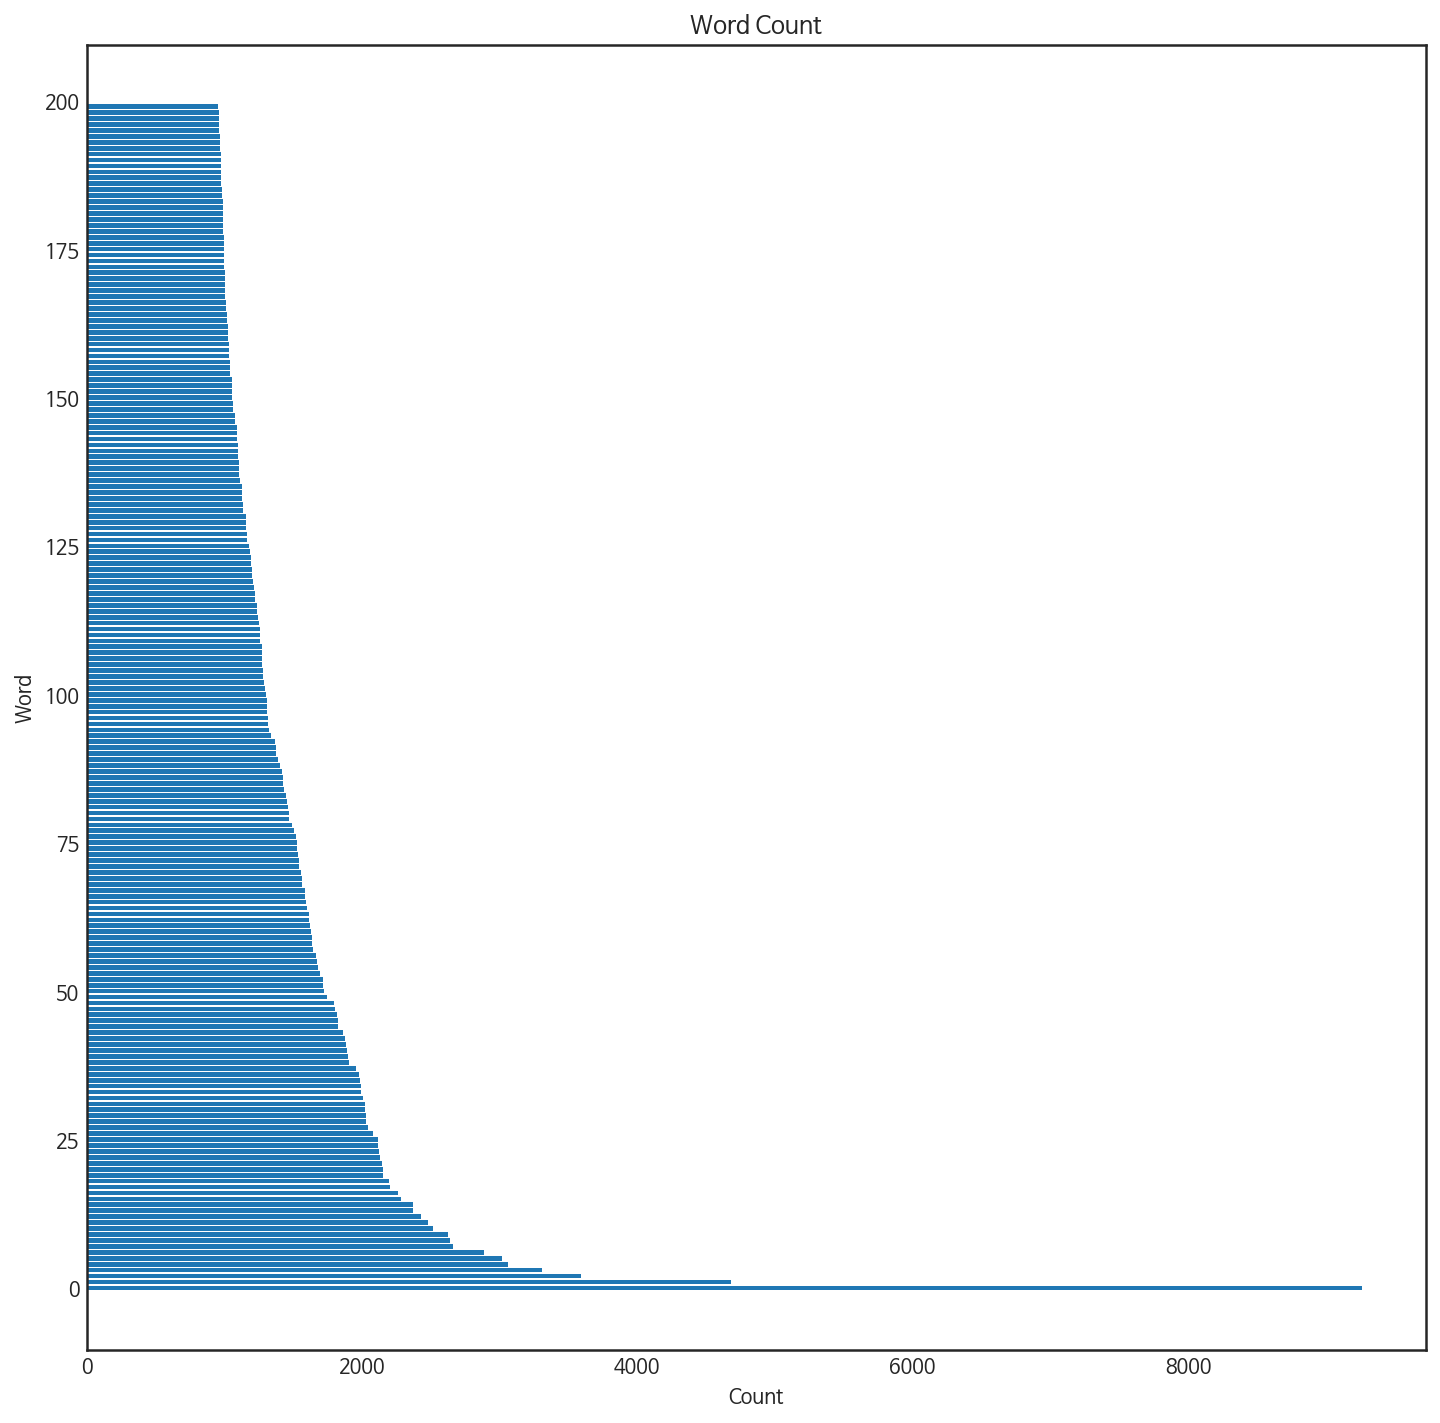

In [ ]:
# top 200
word_freq_dic = dict(zip(word_freq['단어'][:200].tolist(), word_freq['빈도수'][:200].tolist()))

y_pos = np.arange(len(word_freq_dic))

plt.figure(figsize=(12,12))
plt.barh(y_pos, word_freq_dic.values())
plt.title('Word Count')
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

### 워드크라우드

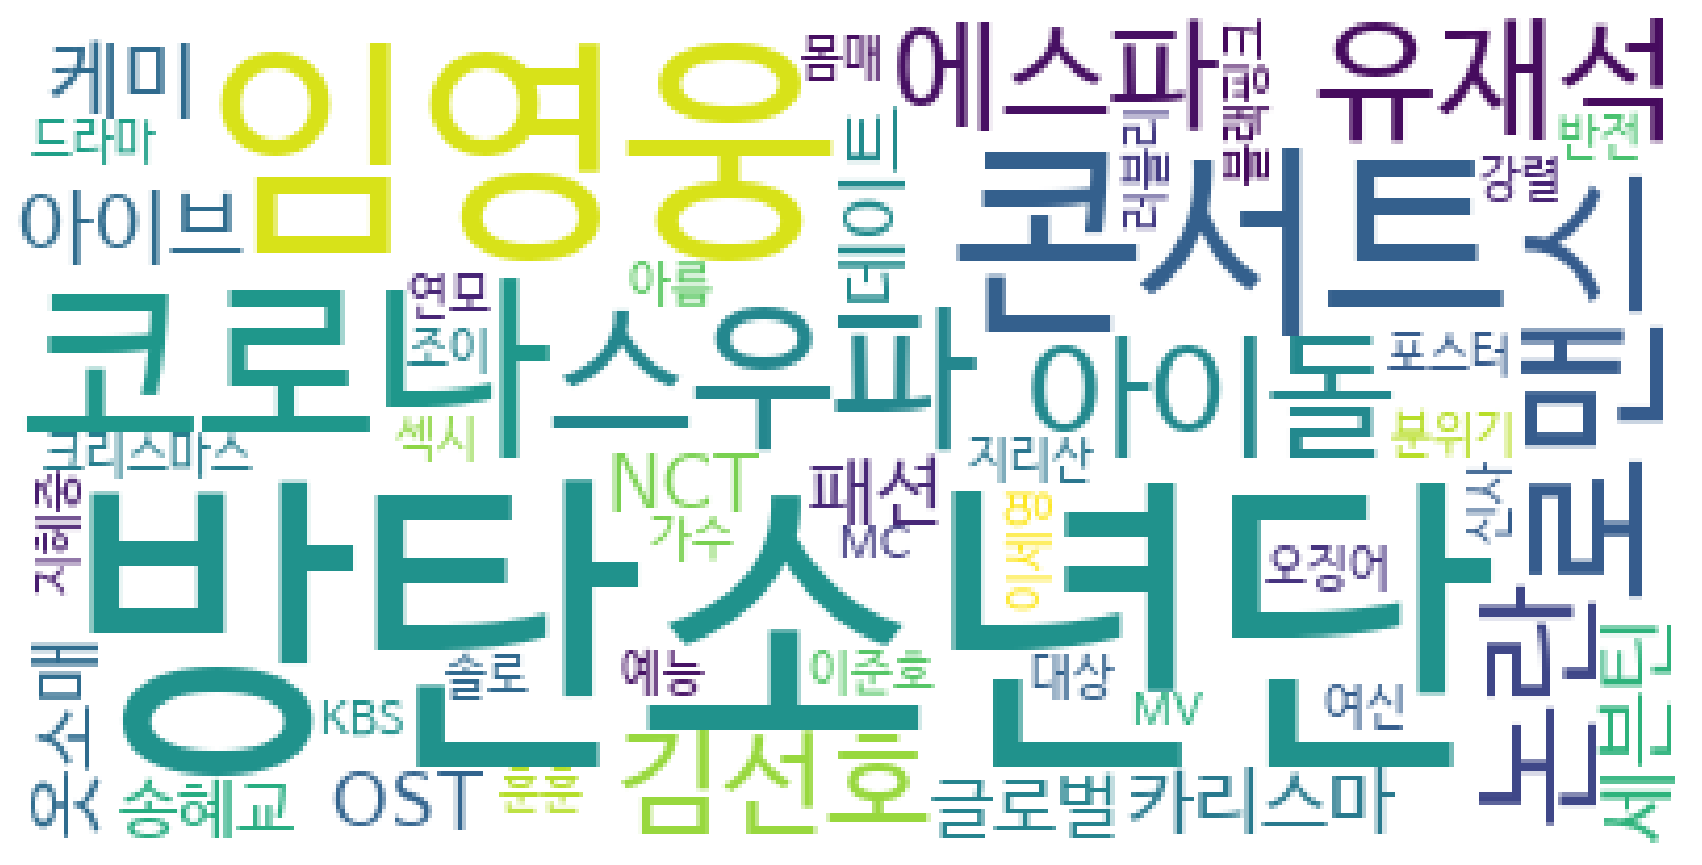

In [ ]:
# top 50
word_freq_dic = dict(zip(word_freq['단어'][:50].tolist(), word_freq['빈도수'][:50].tolist()))

wc = WordCloud(background_color='white', font_path='/content/drive/MyDrive/3조_final_project/98_코딩파일/NanumBarunGothic.ttf')
wc.generate_from_frequencies(word_freq_dic)

figure = plt.figure(figsize=(15, 15))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()

In [ ]:
# # 저장
# cloud.to_file('word_freq_200.jpg')

## 1-2 TF-IDF

In [ ]:
docs = df['noun'].apply(lambda x: ' '.join(x)).tolist()

# 모델
vect = TfidfVectorizer(max_features=1000, stop_words=stop_words)
tfvect = vect.fit_transform(docs)

# 데이터 프레임
word_tf = pd.DataFrame({
    '단어': vect.get_feature_names(),
    'TF-IDF': tfvect.sum(axis=0).flat
})

# TF-IDF에 따라 내림차순
word_tf.sort_values('TF-IDF', ascending=False, inplace=True)

# 인덱스 
word_tf.reset_index(drop=True, inplace=True)

In [ ]:
for i in range(10,13) :
  docs = globals()['df_{}'.format(i)]['제목'].tolist()

  # 모델
  tfvect = vect.fit_transform(docs)

  # 데이터 프레임으로
  globals()['word_tf_{}'.format(i)] = pd.DataFrame(data=[vect.get_feature_names(), tfvect.sum(axis=0).flat])
  globals()['word_tf_{}'.format(i)] = globals()['word_tf_{}'.format(i)].T

  # 컬럼명 변경
  globals()['word_tf_{}'.format(i)].columns = ['{}월 명사'.format(i), '{}월 TF-IDF'.format(i)]

  # TF-IDF에 따라 내림차순
  globals()['word_tf_{}'.format(i)].sort_values(by='{}월 TF-IDF'.format(i), ascending=False, inplace=True)

  # 인덱스 
  globals()['word_tf_{}'.format(i)].reset_index(drop=True, inplace=True)

In [ ]:
# 전체
word_tf[:300]

,단어,TF-IDF
0,방탄소년단,4606.939049
1,임영웅,2501.182882
2,콘서트,1975.729066
3,아이돌,1661.849123
4,코로나,1641.587857
5,스우파,1630.972273
6,에스파,1608.322398
7,로맨스,1577.302964
8,세븐틴,1566.280044
9,논란,1482.278918


In [ ]:
# 월별 top 20
word_tf_month = pd.DataFrame()
for i in range(10,13):
  word_tf_month = pd.concat([word_tf_month, globals()['word_tf_{}'.format(i)]], axis=1)

In [ ]:
word_tf_month.iloc[:100,::2]

,10월 명사,11월 명사,12월 명사
0,방탄소년단,방탄소년단,방탄소년단
1,김선호,임영웅,아이브
2,세븐틴,콘서트,임영웅
3,스우파,화사,크리스마스
4,임영웅,로맨스,옷소매
5,오징어,bts,코로나
6,부산국제영화제,스우파,설강화
7,에스파,정동원,이준호
8,오징어게임,아이돌,콘서트
9,nct,원어스,유재석


## 1-3 토픽 모델링 (Topic Modeling)
- 토픽 모델링: 문서 집합에서 주제를 찾아내기 위한 기술

### 평가기준 (Measure)
1. Coherence (일관성) \
해당 토픽 모델의 모델링이 잘 되었을수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 됨. 따라서 상위 단어 간의 유사도를 계산하면 실제로 해당 주제가 의미론적으로 일치하는 단어들끼리 모여있는지 알 수 있습니다.

  - 주의사항! \
  문서 집합의 Coherence 가 높아지면 monotonic 해지는 문제점이 생김. 마치 Bias-Variance tradeoff 처럼, 만약 coherence가 너무 높아지면 정보의 양이 줄어들게 되고, coherence가 너무 낮아지면 정보들이 일관성이 없어짐.

2. Perplexity (혼란도) \
Perlexity값이 작으면 토픽모델이 문서를 잘 반영된다고 할 수 있음. 그러나 Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님


* Recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated. Optimizing for perplexity may not yield human interpretable topics. This limitation of perplexity measure served as a motivation for more work trying to model the human judgment, and thus Topic Coherence. The concept of topic coherence combines a number of measures into a framework to evaluate the coherence between topics inferred by a model. \
 출처: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0


In [ ]:
texts = np.array(df['noun'])
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
print(corpus[1])

[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


### LSA
- 잠재 의미 분석(Latent Semantic Analysis) = 잠재 의미 인덱싱(Latent Semantic Indexing, LSI)
* 잠재 의미 분석(LSA)은 주로 문서 색인의 의미 검색에 사용
* LSA의 목표는 문서와 단어의 기반이 되는 잠재적인 토픽을 발견하는 것
* 잠재적인 토픽은 문서에 있는 단어들의 분포를 주도한다고 가정

* BoW에 기반한 DTM이나 TF-IDF는 기본적으로 단어의 빈도 수를 이용한 수치화 방법이기 때문에 단어의 의미를 고려하지 못한다는 단점이 있음

* LSA는 쉽고 빠르게 구현이 가능할 뿐만 아니라 단어의 잠재적인 의미를 이끌어낼 수 있어 문서의 유사도 계산 등에서 좋은 성능을 보여준다는 장점을 갖고 있음. 하지만 SVD의 특성상 이미 계산된 LSA에 새로운 데이터를 추가하여 계산하려고 하면 보통 처음부터 다시 계산해야 함. 즉, 새로운 정보에 대해 업데이트가 어려움. 이는 최근 LSA 대신 Word2Vec 등 단어의 의미를 벡터화할 수 있는 또 다른 방법론인 인공 신경망 기반의 방법론이 각광받는 이유임.

In [ ]:
lsi_model = LsiModel(corpus, num_topics=14, id2word=dictionary)
topics = lsi_model.print_topics()
topics

[(0,
  '0.956*"방탄소년단" + 0.113*"뷔" + 0.096*"지민" + 0.087*"콘서트" + 0.079*"정국" + 0.069*"빌보드" + 0.053*"2AM" + 0.051*"콜드플레이" + 0.039*"아미" + 0.038*"OST"'),
 (1,
  '0.749*"임영웅" + 0.281*"신사" + 0.272*"아가씨" + 0.199*"지현우" + 0.192*"이세희" + 0.089*"기부" + 0.084*"아이돌" + 0.080*"OST" + -0.077*"방탄소년단" + 0.074*"도망"'),
 (2,
  '-0.487*"신사" + -0.474*"아가씨" + 0.428*"임영웅" + -0.366*"지현우" + -0.349*"이세희" + -0.120*"박하나" + 0.062*"홍천기" + 0.056*"기부" + 0.055*"에스파" + 0.053*"아이돌"'),
 (3,
  '0.517*"김선호" + 0.294*"갯마을" + 0.291*"차차차" + 0.250*"옷소매" + 0.216*"이준호" + 0.212*"로맨스" + 0.206*"신민아" + -0.198*"임영웅" + 0.183*"이세영" + 0.135*"송혜교"'),
 (4,
  '0.499*"김선호" + -0.329*"옷소매" + -0.286*"이준호" + 0.275*"갯마을" + 0.272*"차차차" + -0.241*"이세영" + -0.193*"로맨스" + 0.192*"신민아" + -0.159*"송혜교" + -0.143*"지헤중"'),
 (5,
  '-0.611*"코로나" + -0.352*"확진" + -0.251*"블랙핑크" + -0.235*"유재석" + 0.183*"옷소매" + 0.160*"이준호" + -0.150*"리사" + -0.139*"스우파" + 0.138*"로맨스" + 0.134*"이세영"'),
 (6,
  '-0.684*"지리산" + -0.495*"전지현" + -0.410*"주지훈" + 0.148*"옷소매" + 0.133*"이준호" + 0.111*"이세영"

### LDA

- 잠재 디리클레 할당(Latent Dirichlet Allocation)
* 잠재 디레클레 할당 방법
  1. 사용자가 토픽이 개수를 지정해 알고리즘에 전달
  2. 모든 단어들을 토픽 중 하나에 할당
  3. 모든 문서의 모든 단어에 대해 단어 w가 가정에 의거, $p(t|d)$, $p(w|t)$에 따라 토픽을 재할당, 이를 반복, 이 때 가정은 자신만이 잘못된 토픽에 할당되어 있고 다른 모든 단어는 올바른 토픽에 할당된다는 것을 의미    

  * $p(t|d)$ - 문서 d의 단어들 중 토픽 t에 해당하는 비율  

  * $p(w|t)$- 단어 w를 가지고 있는 모든 문서들 중  토픽 t가 할당된 비율

* LDA는 문서들은 토픽들의 혼합으로 구성되어져 있으며, 토픽들은 확률 분포에 기반하여 단어들을 생성한다고 가정. 데이터가 주어지면, LDA는 문서가 생성되던 과정을 역추적.

- LSA : DTM을 차원 축소 하여 축소 차원에서 근접 단어들을 토픽으로 묶는다.
- LDA : 단어가 특정 토픽에 존재할 확률과 문서에 특정 토픽이 존재할 확률을 결합확률로 추정하여 토픽을 추출한다.

In [ ]:
# lda_model = LdaModel(corpus, num_topics=14, id2word=dictionary,          
#                      passes=1, decay=0.5, offset=1.0,                    
#                      update_every=1, alpha='symmetric', eta=None,         
#                      distributed=False, chunksize=2000,  eval_every=10, iterations=50,  
#                      gamma_threshold=0.001, minimum_probability=0.01, 
#                      random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None)

#### 최적화 (Optimization)
- LDA 공식 문서: https://radimrehurek.com/gensim/models/ldamodel.html
- LDA 설명 블로그: https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/06/01/LDA/
- LDA 설명 블로그: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#4whatdoesldado

##### Topic 수 변화

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

min_topics, max_topics = 10, 21
coherences_score=[]
perplexities_score=[] 

for num_topics in range(min_topics, max_topics) :
  time_before = time.time()
  lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=1)
  print('num_topics "{}"'.format(num_topics))
 
  cm = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary)

  coherences_score.append(cm.get_coherence())
  perplexities_score.append(lda_model.log_perplexity(corpus))

  print("Cpherence : ", cm.get_coherence())    
  print('Perplexity : ', lda_model.log_perplexity(corpus))
  print('Time : ', (time.time() - time_before)/60)
  print('='*30)

  vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
  pyLDAvis.save_html(vis, '연예 뉴스_lda({}).html'.format(num_topics))

In [ ]:
# coherences_score = list(map(float, input().split(',')))

0.5606463403016078,  0.5800634686524877,  0.5770662568749336,  0.5710696893735225,  0.5740812716212229,  0.5627340543688025,  0.5604435651849898,  0.5624931739157856,  0.5724032834128098,  0.5729830860209748,  0.5744574044372843,  0.57335540115811,  0.5663557070220774,  0.5690522501204729,  0.5702020919942391,  0.577346591032555,  0.5753750291669582,  0.5818346531371396,  0.5658139554927297,  0.5742027444093347,  0.5757045869341131,  0.58270128272278,  0.5794656387811793,  0.5778669755474058,  0.5789591643426244,  0.5701820472273792,  0.5746937502117462,  0.5764215212770366,  0.5802698188703737,  0.5821574715504217,  0.5795574285482313,  0.5715690238671118,  0.5743739340365555,  0.5776264368031663,  0.5761269175500977,  0.5802466123213622,  0.5838016020961797,  0.5802691264341249,  0.5769246084316582,  0.5810963495218392,  0.5744788661603923,  0.5812050797760386,  0.583849978706933,  0.5801154577148778,  0.5824039453637039,  0.5821330288581824,  0.5796817318364914,  0.583220692266716, 

In [ ]:
# perplexities_score = list(map(float, input().split(',')))

-11.138551418474703,  -11.185985580347761,  -11.229936806212736,  -11.277834624812366,  -11.31506056552991,  -11.347456257266678,  -11.39251976272328,  -11.42812519464608,  -11.46981309970274,  -11.496336857022266,  -11.544888728040496,  -11.583839441885129,  -11.621011812490163,  -11.654811214730362,  -11.698398764704995,  -11.71722407704667,  -11.762174864039961,  -11.806289771846775,  -11.84487578680003,  -11.87454466910972,  -11.906589049512677,  -11.941287901978919,  -11.976084671779425,  -12.025021930844337,  -12.053690846162151,  -12.085945497405909,  -12.103651541532424,  -12.142301208064373,  -12.178514721491455,  -12.225943675692488,  -12.256013047430388,  -12.279330751038165,  -12.314744172458363,  -12.348347464983473,  -12.380718622358799,  -12.424205293230354,  -12.451167692481368,  -12.482932374641337,  -12.504617960725174,  -12.558740338799389,  -12.577630067844957,  -12.6101678929655,  -12.643601798383093,  -12.67266623122136,  -12.722273717665434,  -12.735669229865143,

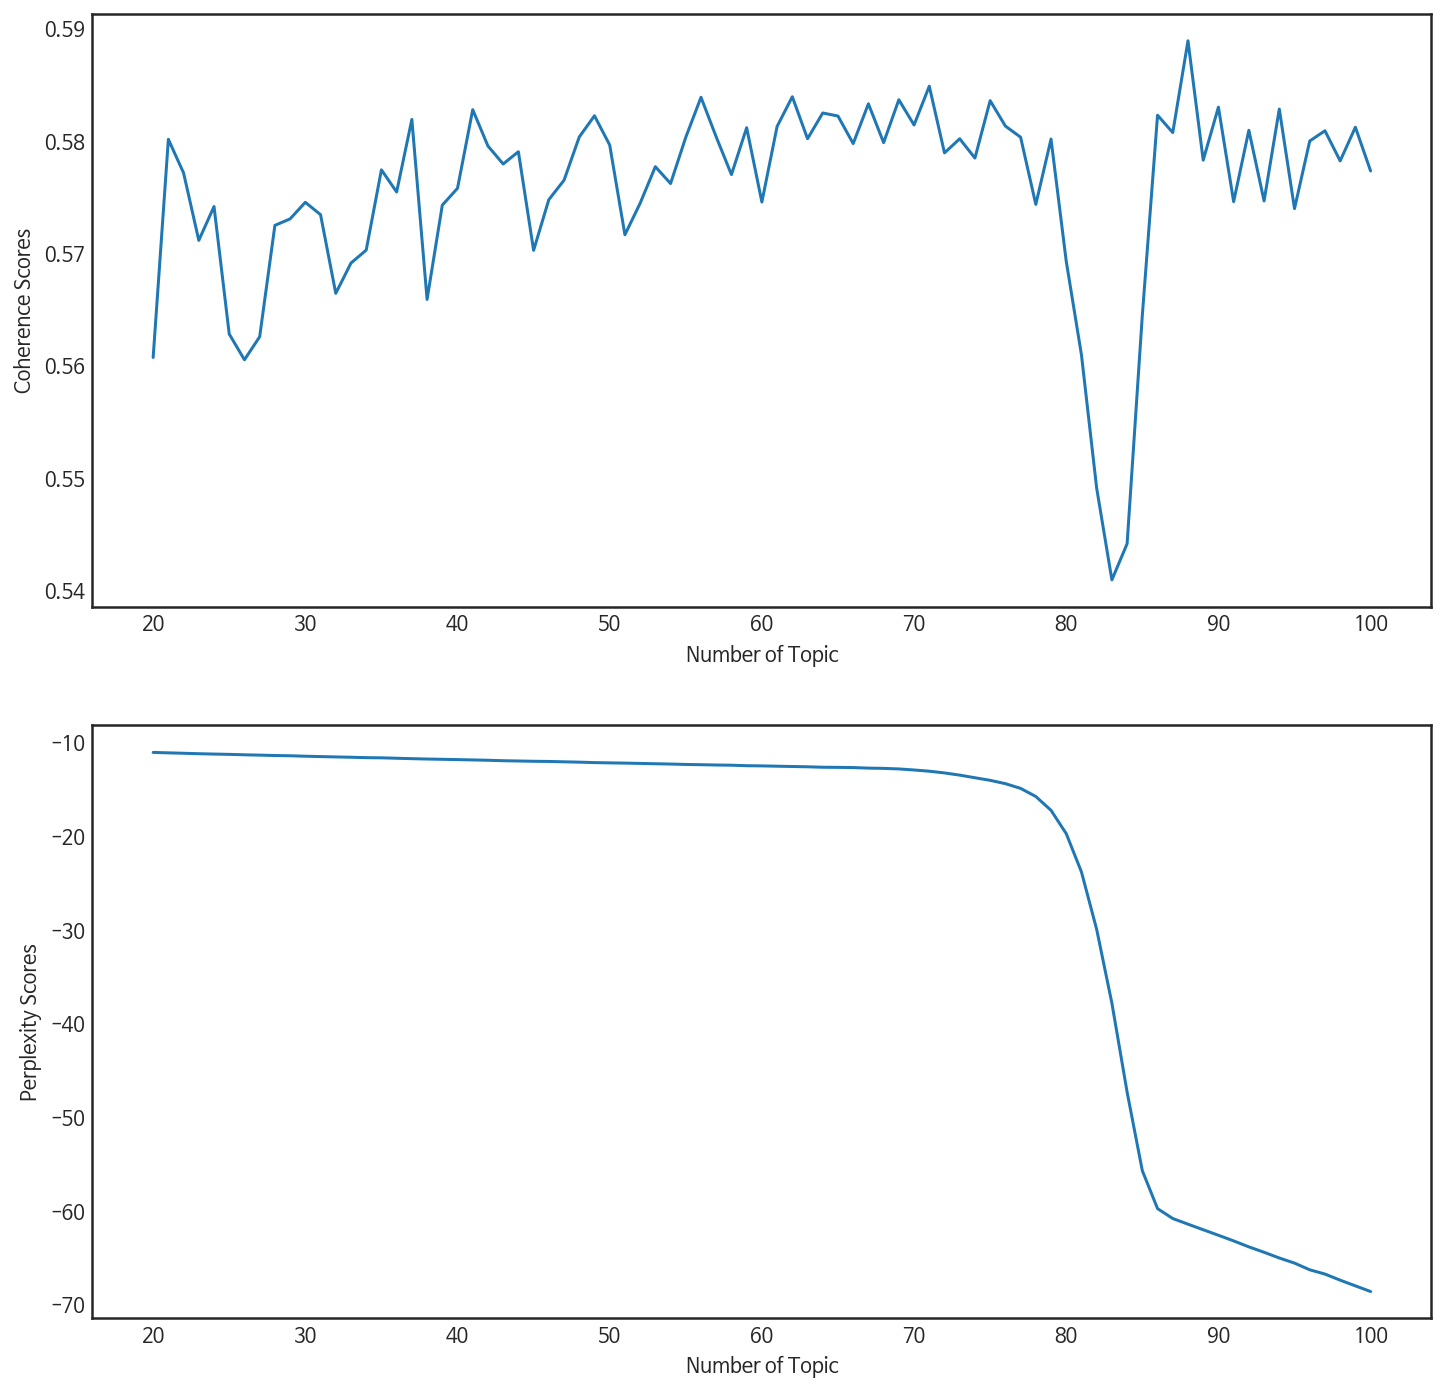

In [ ]:
x = [int(i) for i in range(min_topics, max_topics)]

plt.subplot(2,1,1)
plt.plot(x, coherences_score)
plt.xlabel('Number of Topic')
plt.ylabel('Coherence Scores')

plt.subplot(2,1,2)
plt.plot(x, perplexities_score)
plt.xlabel('Number of Topic')
plt.ylabel('Perplexity Scores')
plt.show();

#### LDA 시각화

In [ ]:
lda_model_88 = LdaModel(corpus, num_topics=88, id2word=dictionary, passes=1)

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_88 = pyLDAvis.gensim.prepare(lda_model_88, corpus, dictionary)
pyLDAvis.display(vis_88)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# 저장
# pyLDAvis.save_html(vis_88, '연예 뉴스_lda(88).html')

# 2 특정 키워드 분석

In [26]:
keyword = '한소희'
keywords = ['방탄소년단','송가인','비오','한소희']

In [27]:
# keywords = list(input().split(' '))

## 2-1 사회 연결망 분석 (Social Network Analysis)

### 동시 출현 단어

#### Bigram

In [28]:
bgrams = [bigrams(x) for x in df['noun'].tolist()]

token = []
for idx, i in enumerate(bgrams) :
  try : 
    token += ([x for x in i])
  except :   # 공백 리스트 예외 처리
    pass
    # print(f'{idx} : {list(i)}')
# token

cfd = ConditionalFreqDist(token)
# cfd.conditions()

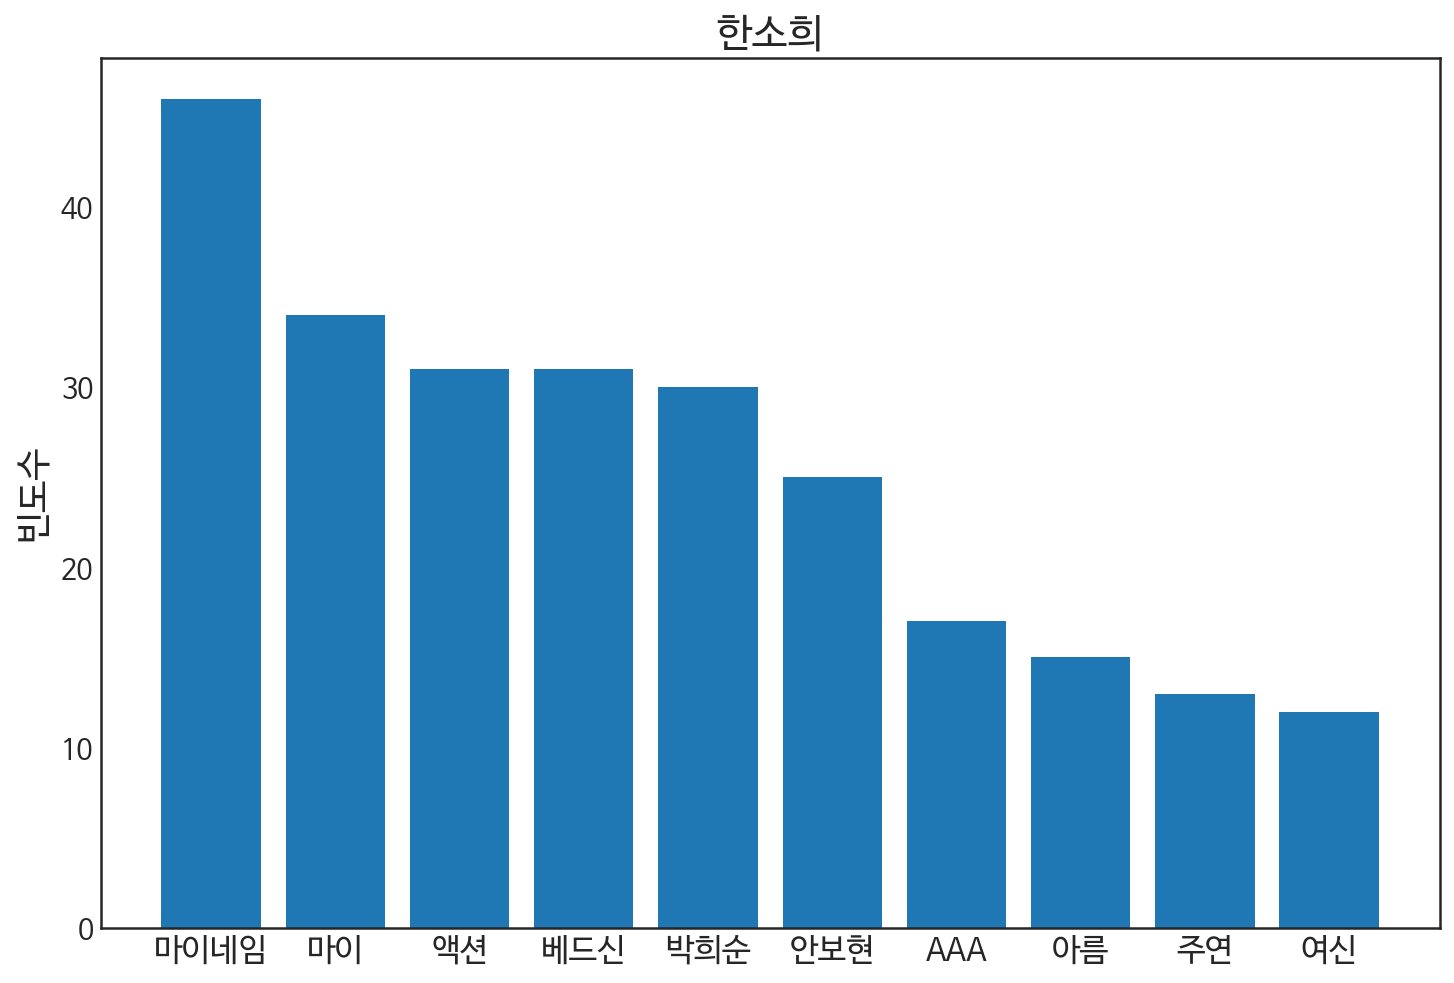

In [29]:
plt.figure(figsize=(12,8))
x = [i[0] for i in cfd[keyword].most_common(10)]
y = [i[1] for i in cfd[keyword].most_common(10)]
plt.bar(x, y)
plt.title(keyword, fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('빈도수', fontsize=18)
plt.show()

In [30]:
# keyword = '공개'
print(cfd[keyword].most_common(10))

# keywords = list(input().split(' '))
# for idx, keyword in enumerate(keywords) :
#   print(idx, keyword, cfd[keyword].most_common(10))

[('마이네임', 46), ('마이', 34), ('액션', 31), ('베드신', 31), ('박희순', 30), ('안보현', 25), ('AAA', 17), ('아름', 15), ('주연', 13), ('여신', 12)]


#### Trigram

In [31]:
# trigram
tgrams = [ngrams(x,3) for x in df['noun'].tolist()]
ttoken = []

for idx, i in enumerate(tgrams) :
  try : 
    ttoken += ([x for x in i])
  except :
    pass
#     print(f'{idx} : {list(i)}')
# ttoken

condition_pairs = ((w0, (w1, w2)) for w0, w1, w2 in ttoken)
cfd_trigrams = ConditionalFreqDist(condition_pairs)

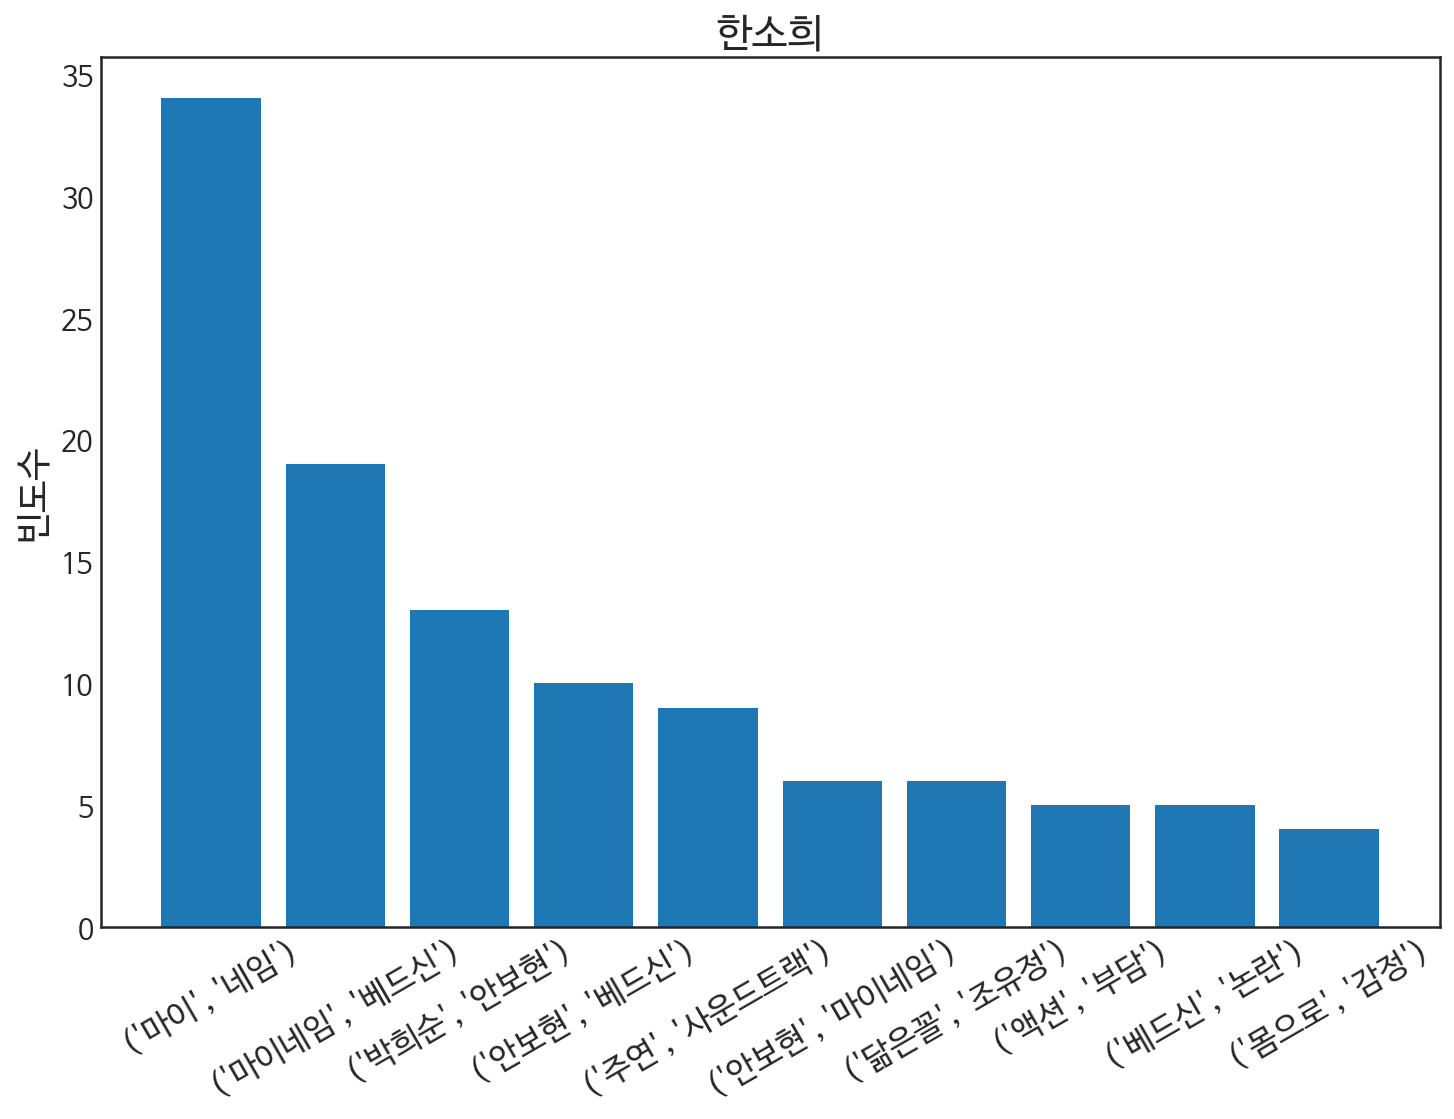

In [32]:
plt.figure(figsize=(12,8))
x = [str(i[0]) for i in cfd_trigrams[keyword].most_common(10)]
y = [i[1] for i in cfd_trigrams[keyword].most_common(10)]
plt.bar(x, y)
plt.title(keyword, fontsize=20)
plt.xticks(fontsize=16, rotation=30)
plt.yticks(fontsize=14)
plt.ylabel('빈도수', fontsize=18)
plt.show()

In [33]:
# keyword = '공개'
print(cfd_trigrams[keyword].most_common(10))

# keywords = list(input().split(' '))
# for idx, keyword in enumerate(keywords) :
#   print(idx, keyword, cfd_trigrams[keyword].most_common(10))

[(('마이', '네임'), 34), (('마이네임', '베드신'), 19), (('박희순', '안보현'), 13), (('안보현', '베드신'), 10), (('주연', '사운드트랙'), 9), (('안보현', '마이네임'), 6), (('닮은꼴', '조유정'), 6), (('액션', '부담'), 5), (('베드신', '논란'), 5), (('몸으로', '감정'), 4)]



### 단어 유사도 (Word2Vec)
- https://radimrehurek.com/gensim/models/word2vec.html
- https://hoonzi-text.tistory.com/2

In [34]:
w2v = Word2Vec(sentences=df['noun'].tolist(), size=200, window=5, min_count=4, workers=4, sg=0)
# workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).
# sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

# w2v.wv.vocab.keys()
w2v.wv.vectors.shape

(35462, 200)

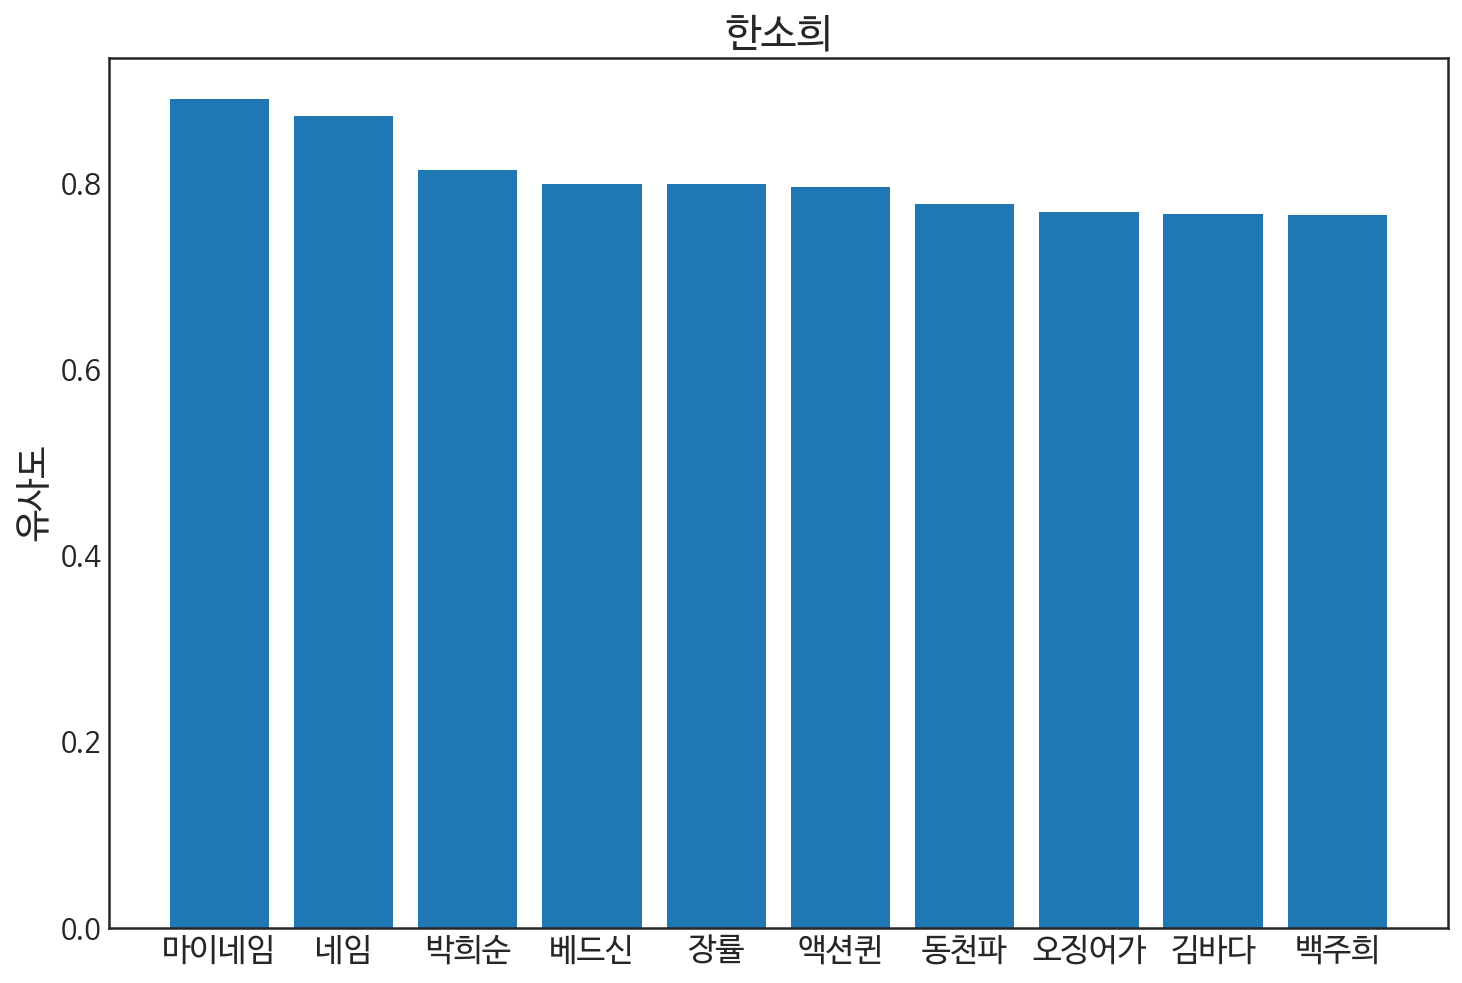

In [35]:
plt.figure(figsize=(12,8))
x = [i[0] for i in w2v.wv.most_similar(keyword)]
y = [i[1] for i in w2v.wv.most_similar(keyword)]
plt.bar(x, y)
plt.title(keyword, fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('유사도', fontsize=18)
plt.show()

In [36]:
# keyword = '공개'
print(w2v.wv.most_similar(keyword, topn=20))

# keywords = list(input().split(' '))
# for idx, keyword in enumerate(keywords) :
#   try : print(idx, keyword, w2v.wv.most_similar(keyword, topn=20))
#   except : print(idx, keyword, '없음')

[('마이네임', 0.8896649479866028), ('네임', 0.8720972537994385), ('박희순', 0.8133313655853271), ('베드신', 0.7987469434738159), ('장률', 0.7985433340072632), ('액션퀸', 0.7952148914337158), ('동천파', 0.7775108814239502), ('오징어가', 0.7680821418762207), ('김바다', 0.7661675810813904), ('백주희', 0.7652235627174377), ('김상호', 0.7648826241493225), ('최무진', 0.7544873356819153), ('박예진', 0.7540358901023865), ('뮤직시네마', 0.7500011324882507), ('즈려밟고', 0.7478905916213989), ('마이', 0.7463261485099792), ('근육량', 0.740432858467102), ('김진민', 0.7384691834449768), ('사운드트랙', 0.7160400152206421), ('이상청', 0.7022000551223755)]


#### 시각화
- https://projector.tensorflow.org/

In [37]:
# from gensim.models import KeyedVectors  
# w2v.wv.save_word2vec_format('w2v')   # 모델 저장

In [38]:
# !python -m gensim.scripts.word2vec2tensor --input w2v --output w2v   # 쥬피터에서 실행

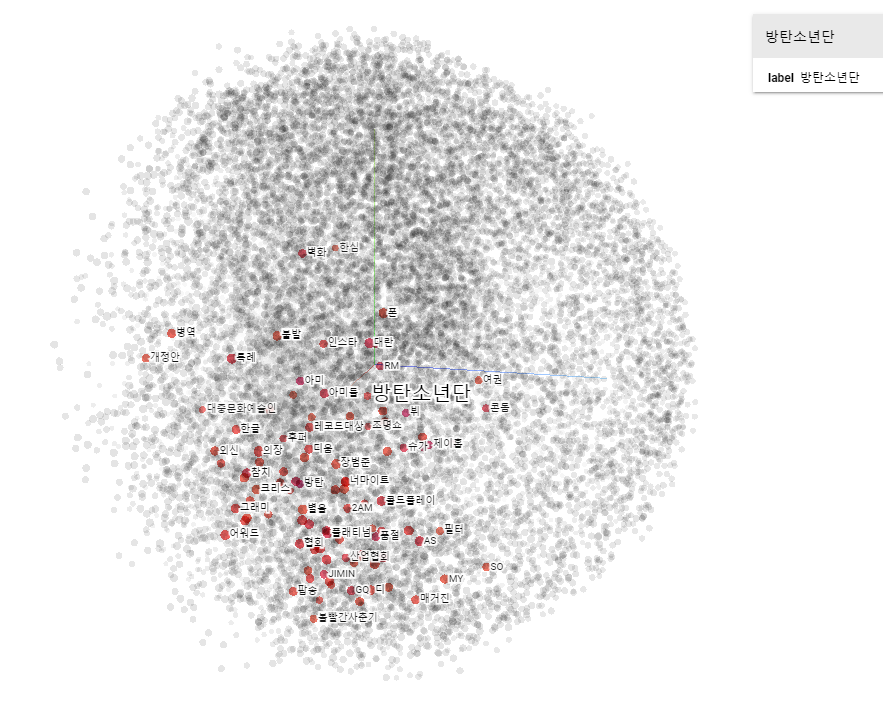

In [39]:
Image('/content/drive/MyDrive/3조_final_project/02_연예 뉴스/EmbeddingProjector_방탄소년단.png')

## 2-2 시계열 분석 (Time Series Analysis)

In [40]:
# 전체
df_time = df[['일자','noun']]
df_time['count'] = df_time['noun'].apply(lambda x : 1 if keyword in x else 0)
df_time = df_time.groupby('일자').sum()
max = df_time['count'].max()
min = df_time['count'].min()
df_time['ratio'] = df_time['count'].apply(lambda x : (x-min)/(max-min)*100)   # normalization

### 뉴스 업급량

In [41]:
# 시계열 분해 (전체)
decompostion_count = sm.tsa.seasonal_decompose(df_time['count'], model='additive', period=30)   # model{“additive”, “multiplicative”}

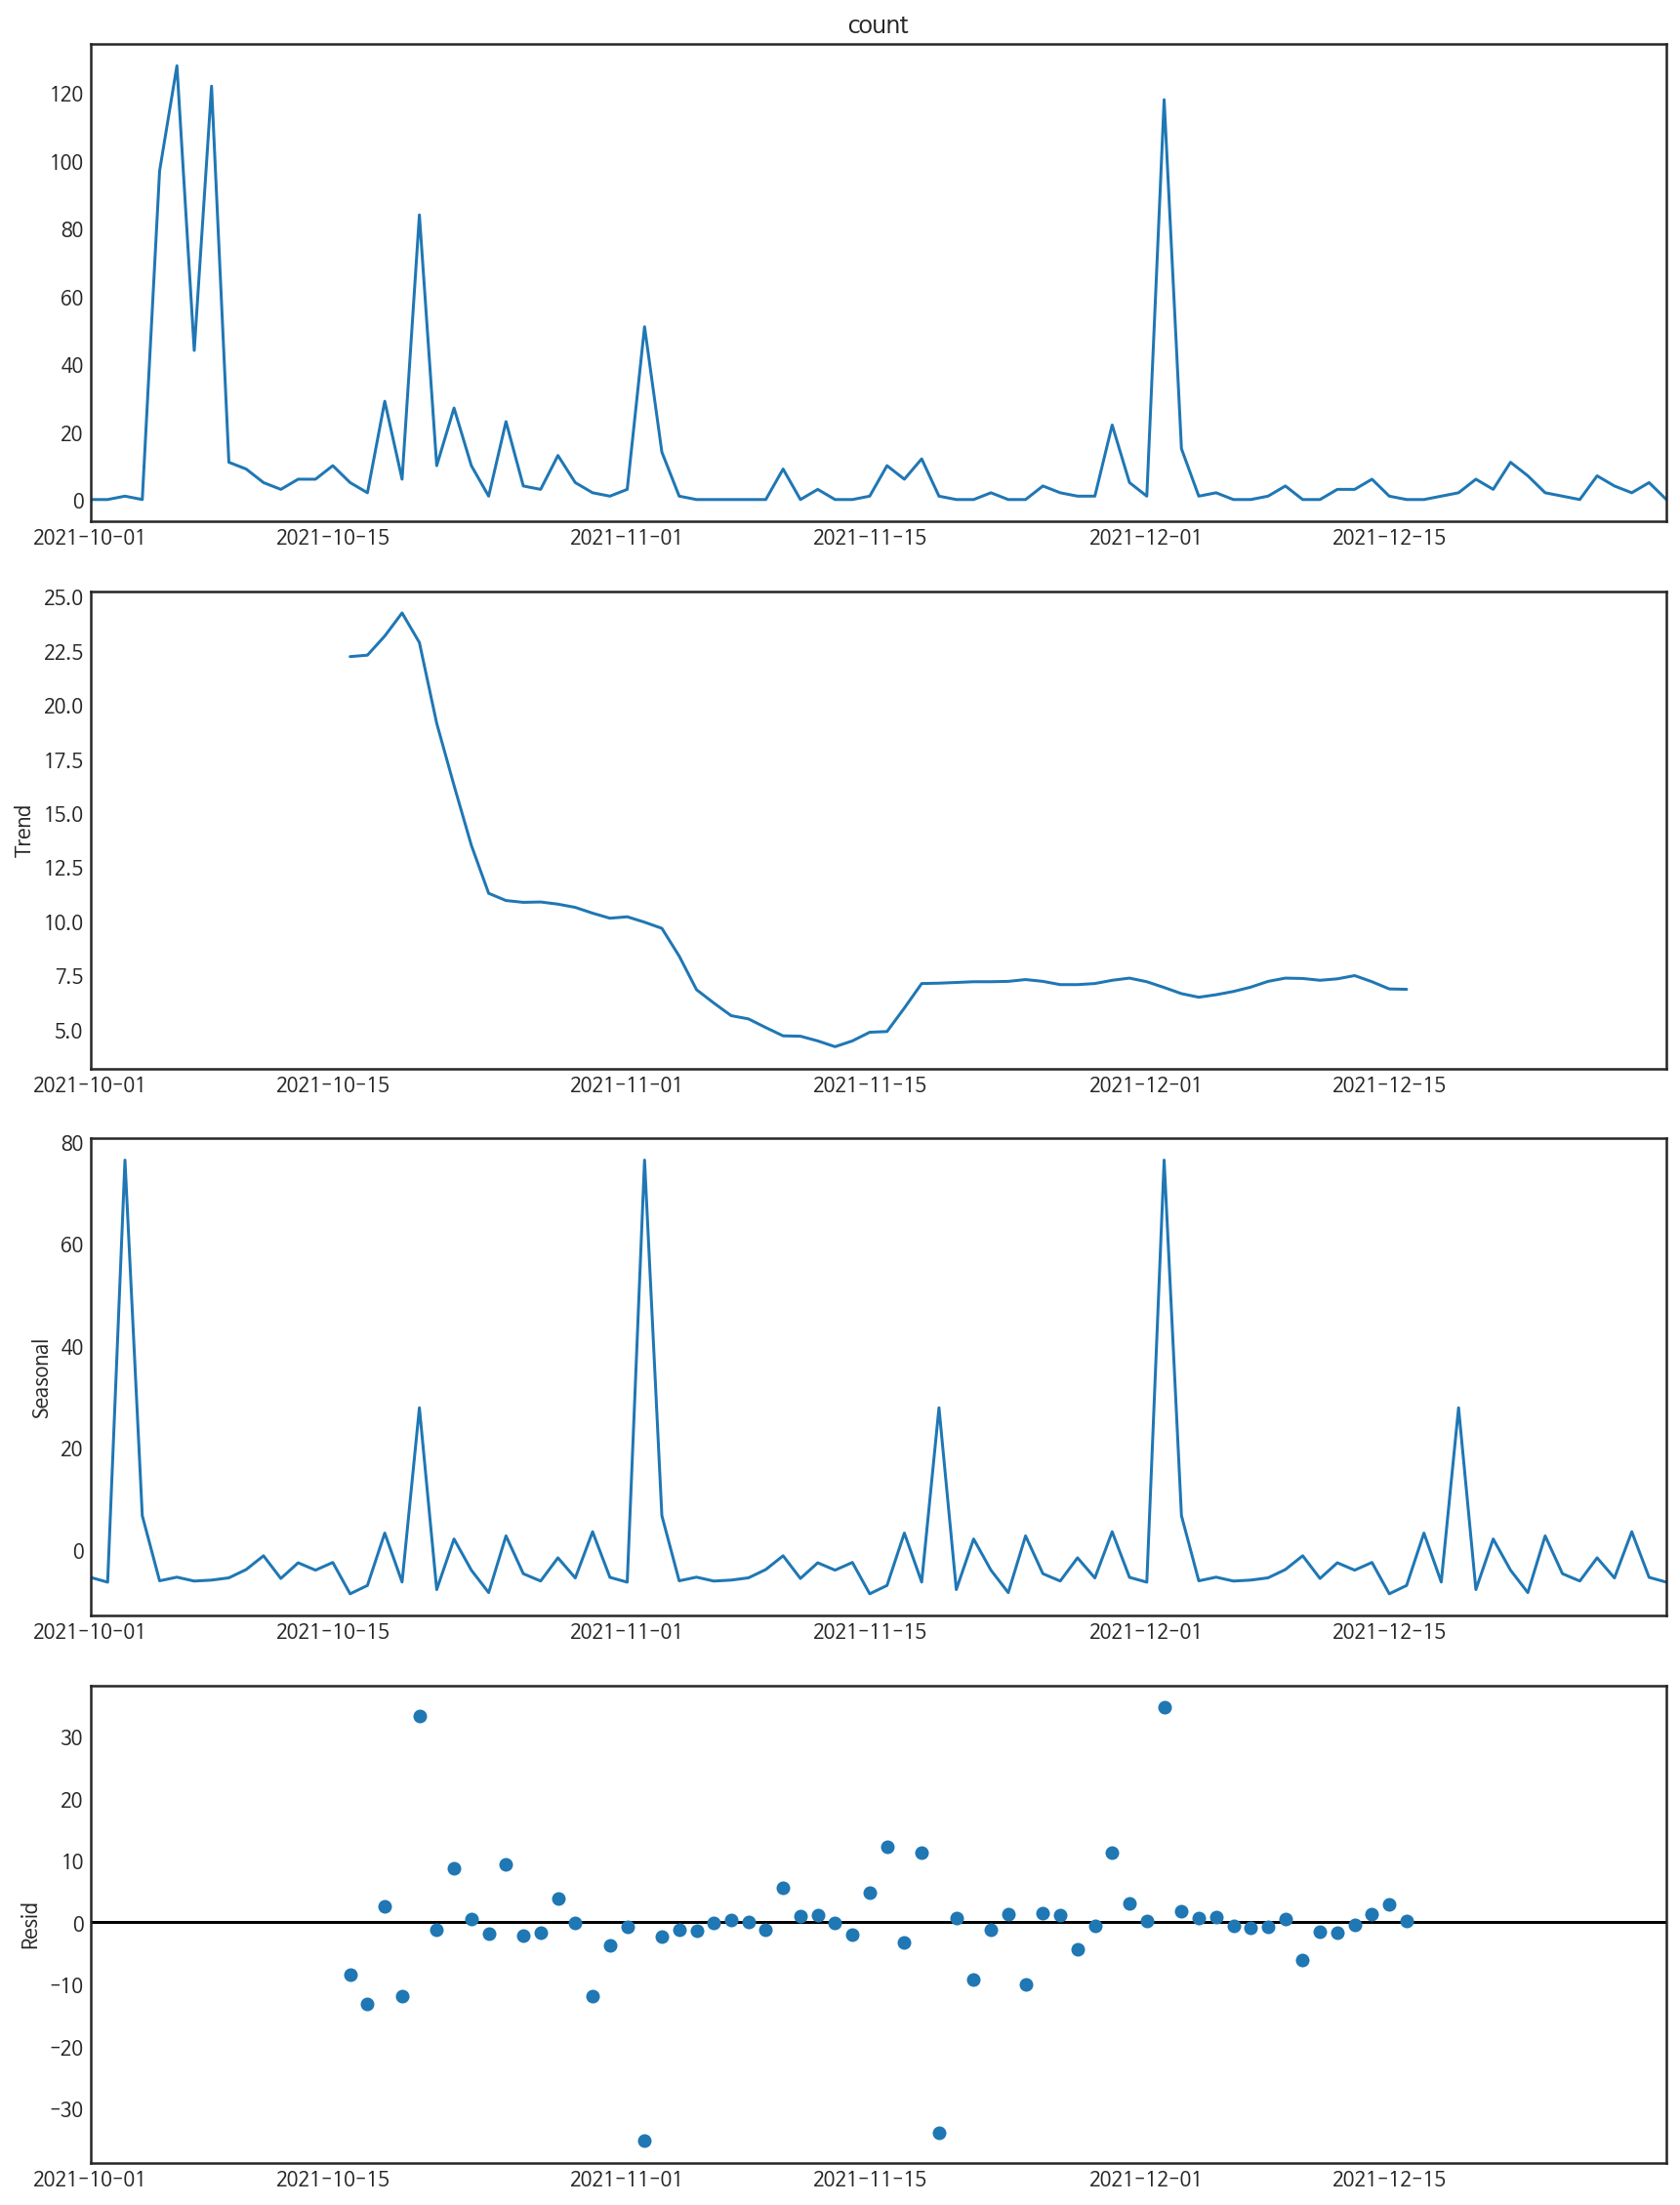

In [42]:
fig = decompostion_count.plot()
fig.set_size_inches(12,16)
plt.show()

In [43]:
# 시계열 분해 (전체)
decompostion_ratio = sm.tsa.seasonal_decompose(df_time['ratio'], model='additive', period=30)   # model{“additive”, “multiplicative”}

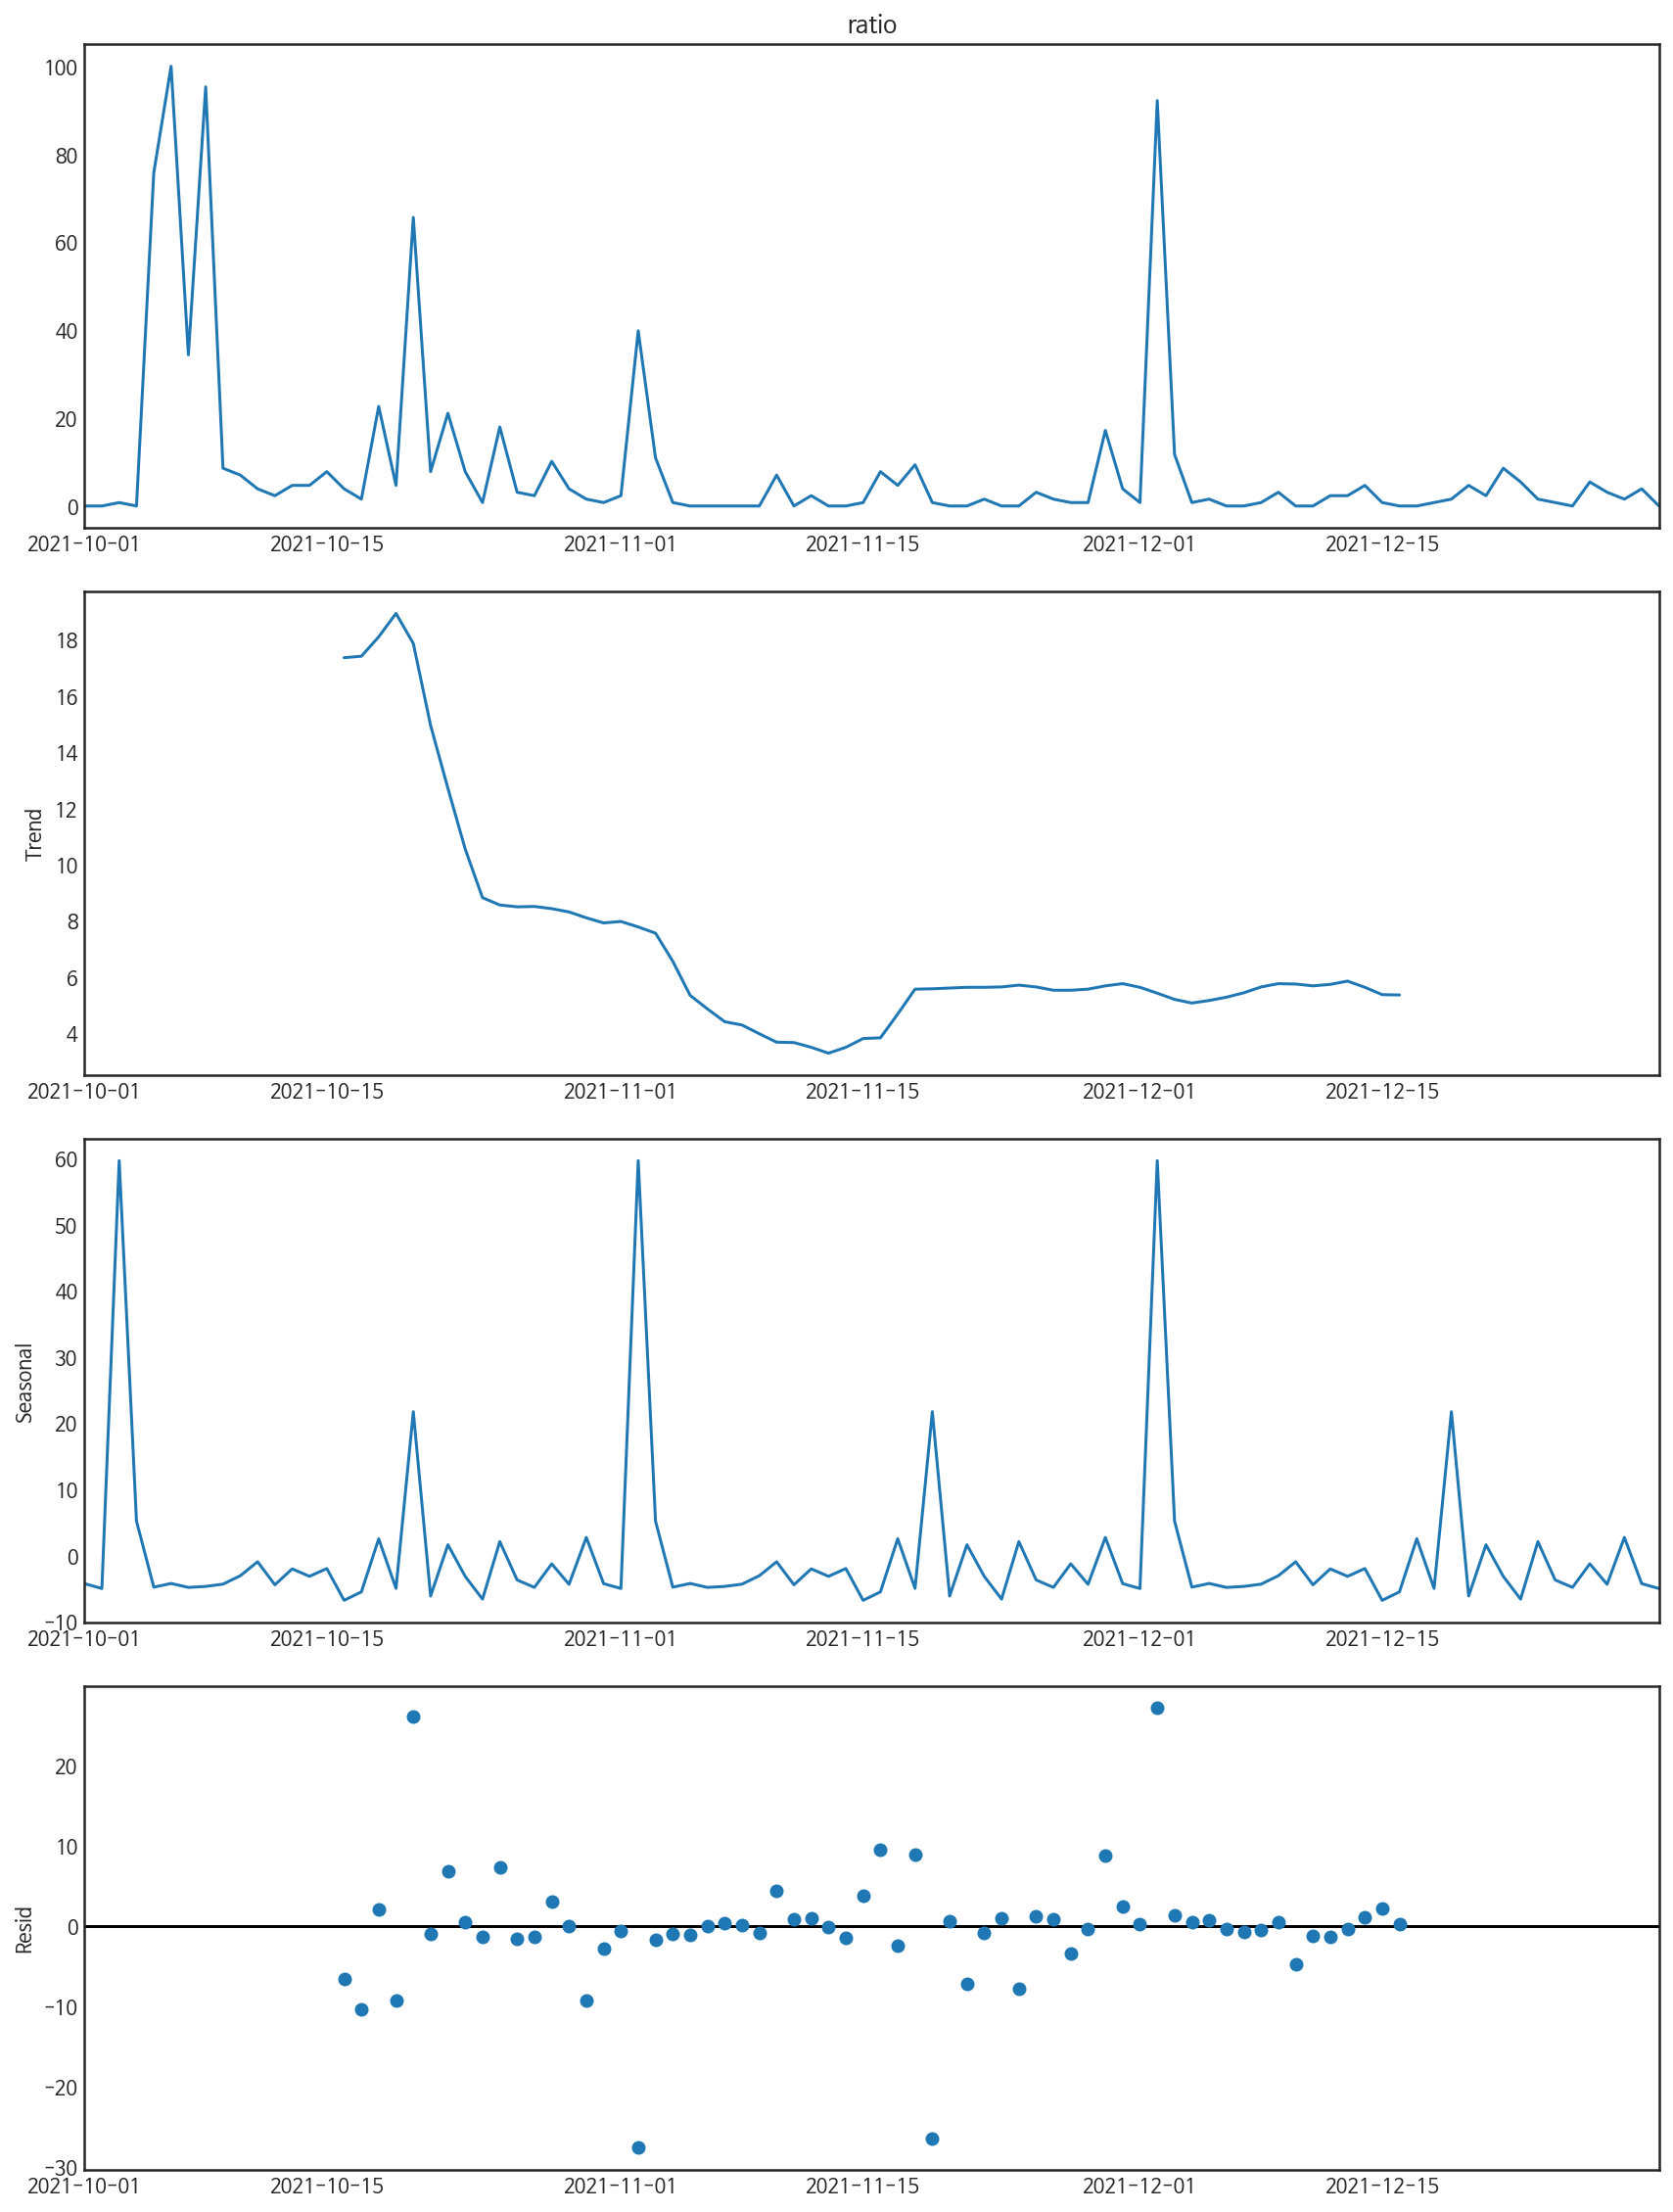

In [44]:
fig = decompostion_ratio.plot()
fig.set_size_inches(12,16)
plt.show()

### 네이버 검색량

In [45]:
df_검색량 = pd.read_excel(r'/content/drive/MyDrive/3조_final_project/02_연예 뉴스/datalab_한소희(2021.10.01~2021.12.31).xlsx')

In [46]:
df_검색량 = df_검색량.iloc[6:]
df_검색량.columns = ['Date','Search_ratio']

In [47]:
df_검색량['Date']=pd.to_datetime(df_검색량['Date'], errors='coerce', format='%Y-%m-%d')
df_검색량.sort_values(by=['Date'], inplace=True)
df_검색량.set_index('Date', inplace=True)

In [48]:
df_검색량['Search_ratio'] = pd.to_numeric(df_검색량['Search_ratio'])

In [49]:
print(df_검색량['Search_ratio'].max())
print(df_검색량['Search_ratio'].min())

100.0
5.80785


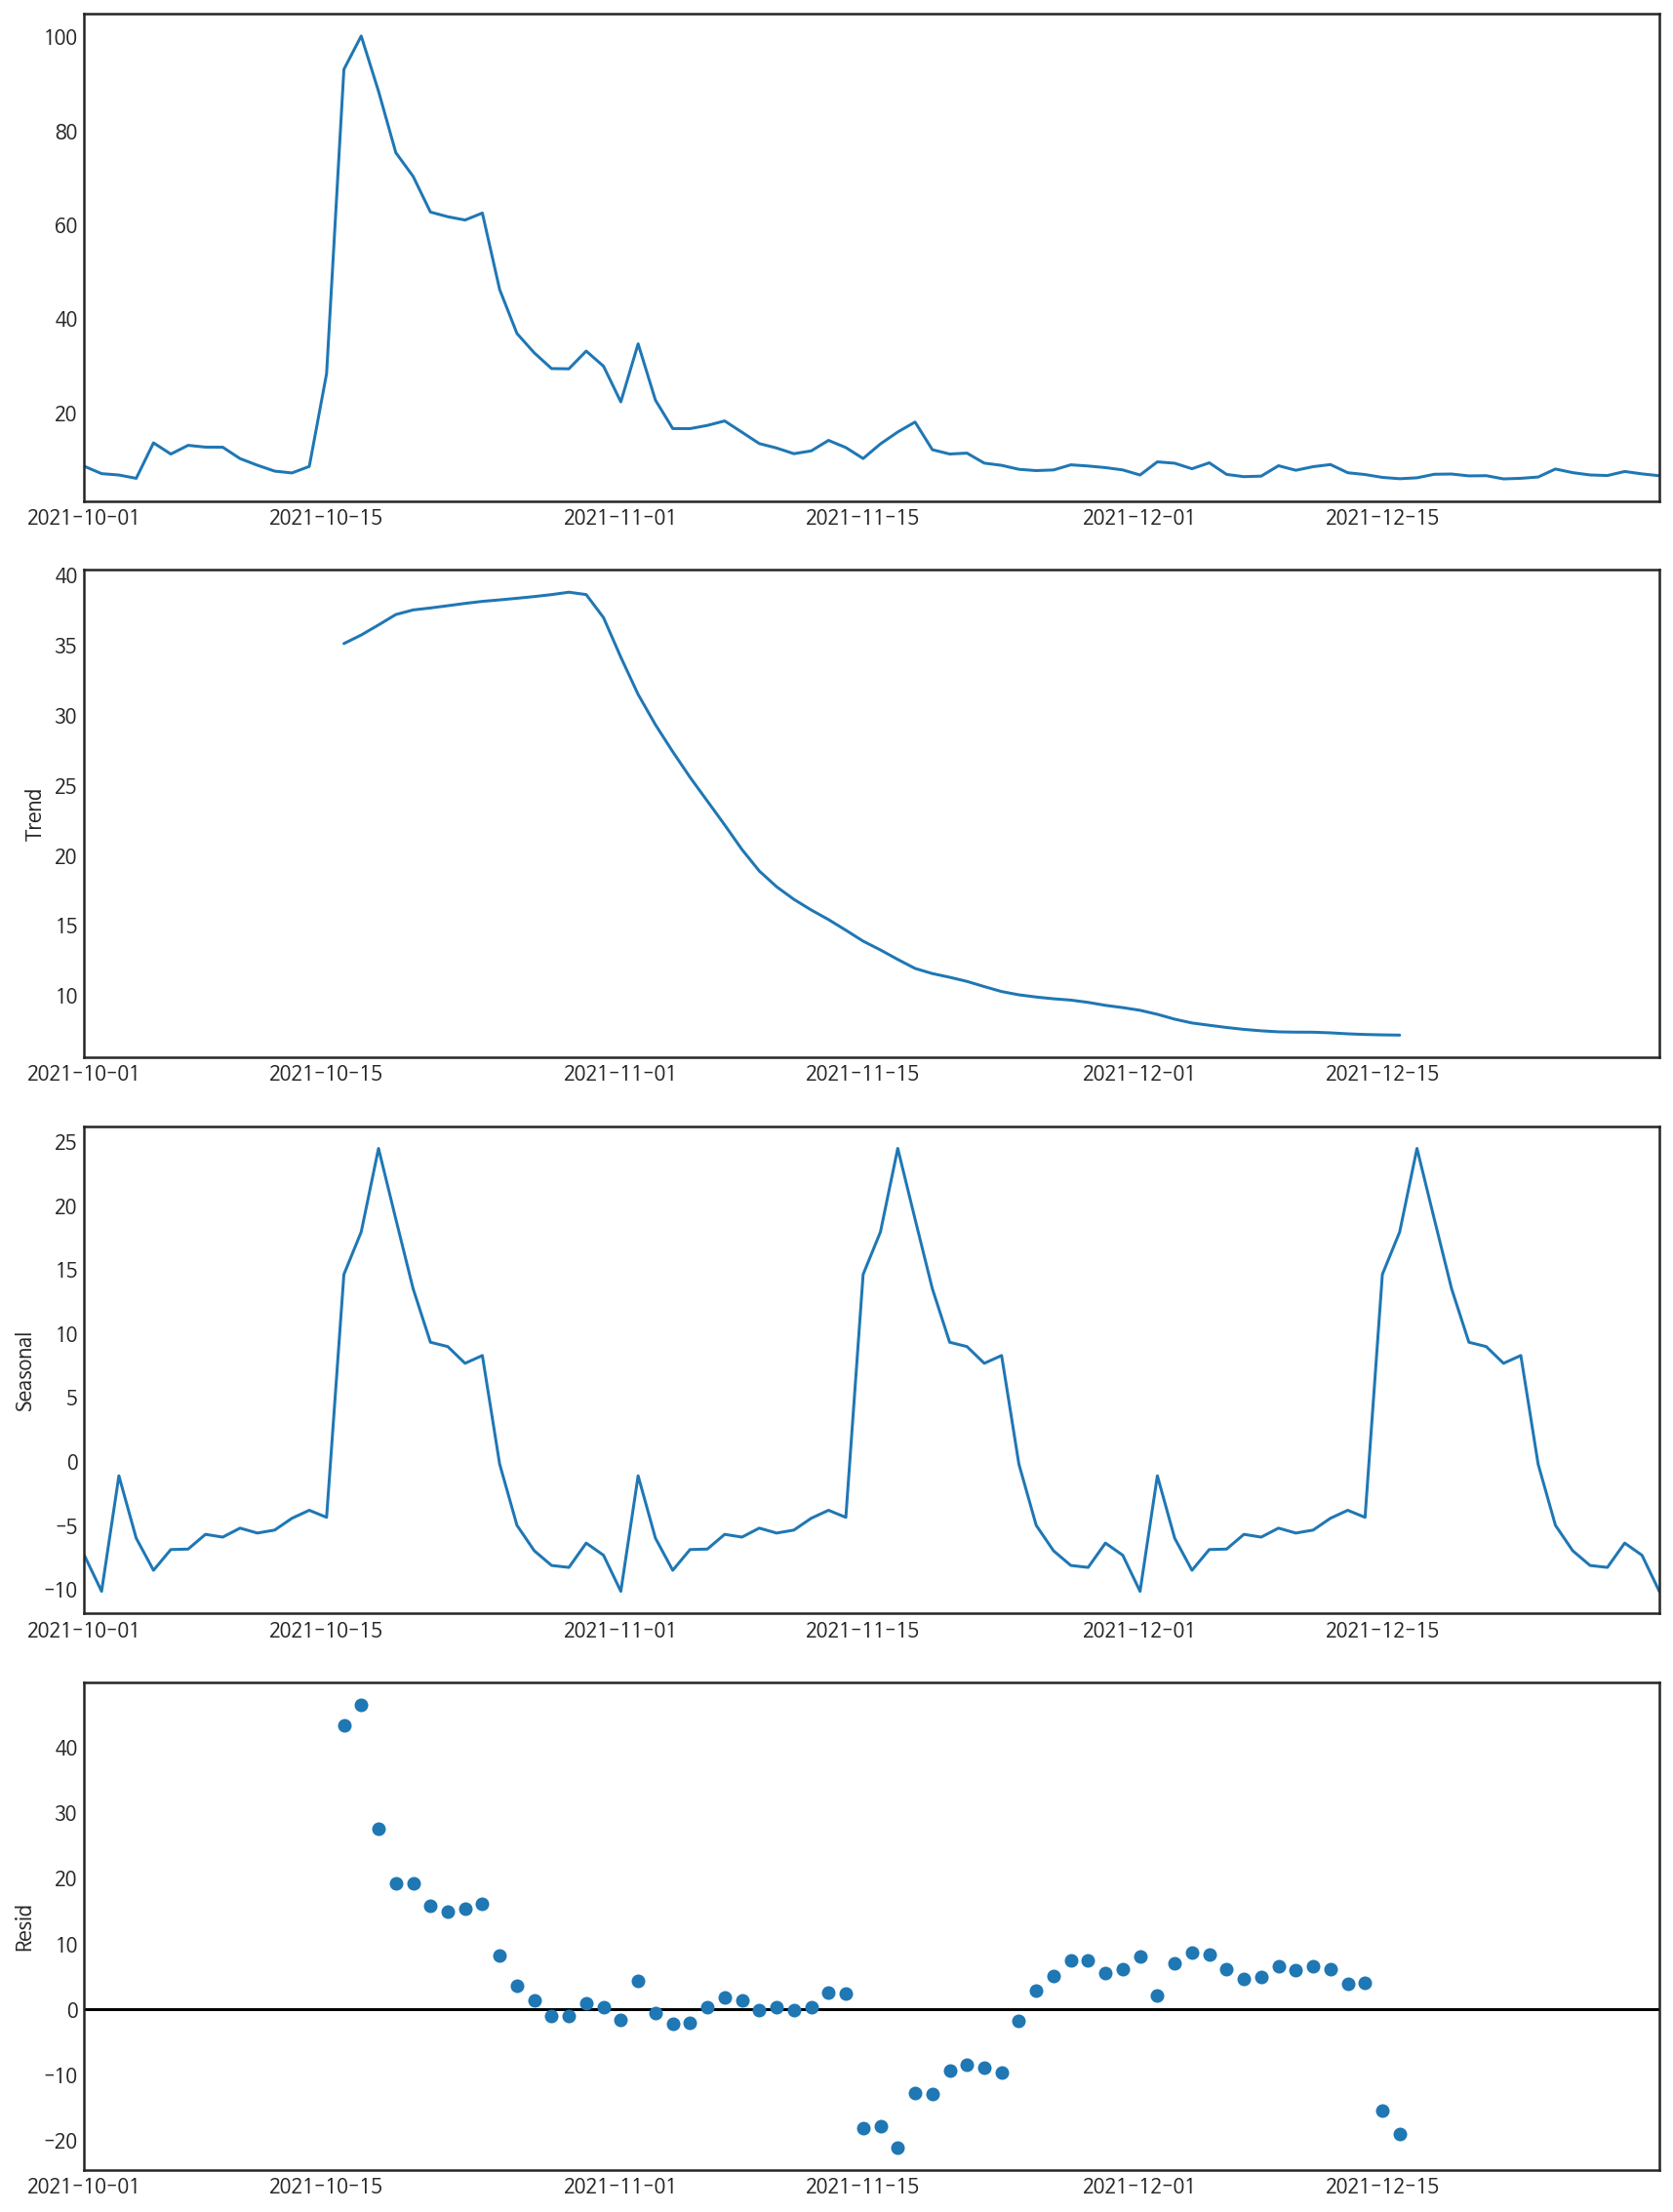

In [50]:
df_검색량_decomposition = sm.tsa.seasonal_decompose(df_검색량, model='additive', period=30)
fig = df_검색량_decomposition.plot()
fig.set_size_inches(12, 16)
plt.show()

### 뉴스 업급량, 네이버 검색량 비교

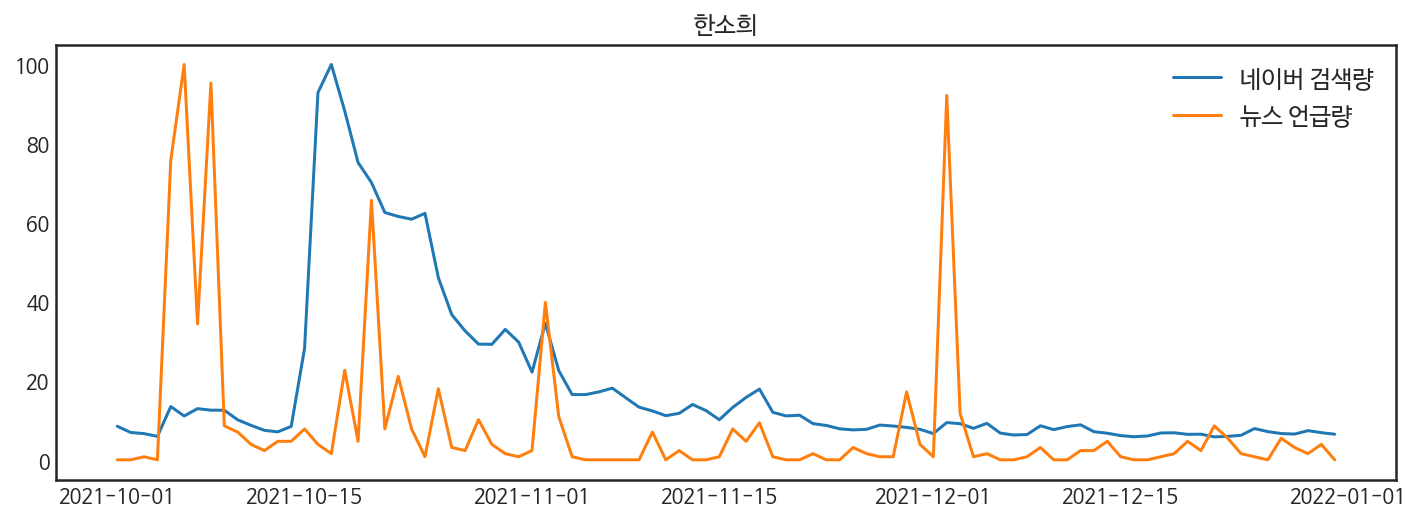

In [51]:
plt.figure(figsize=(12,4))
plt.plot(df_검색량, label='네이버 검색량')
plt.plot(df_time['ratio'], label='뉴스 언급량')
plt.title(keyword)
plt.legend(fontsize=12)
plt.show()

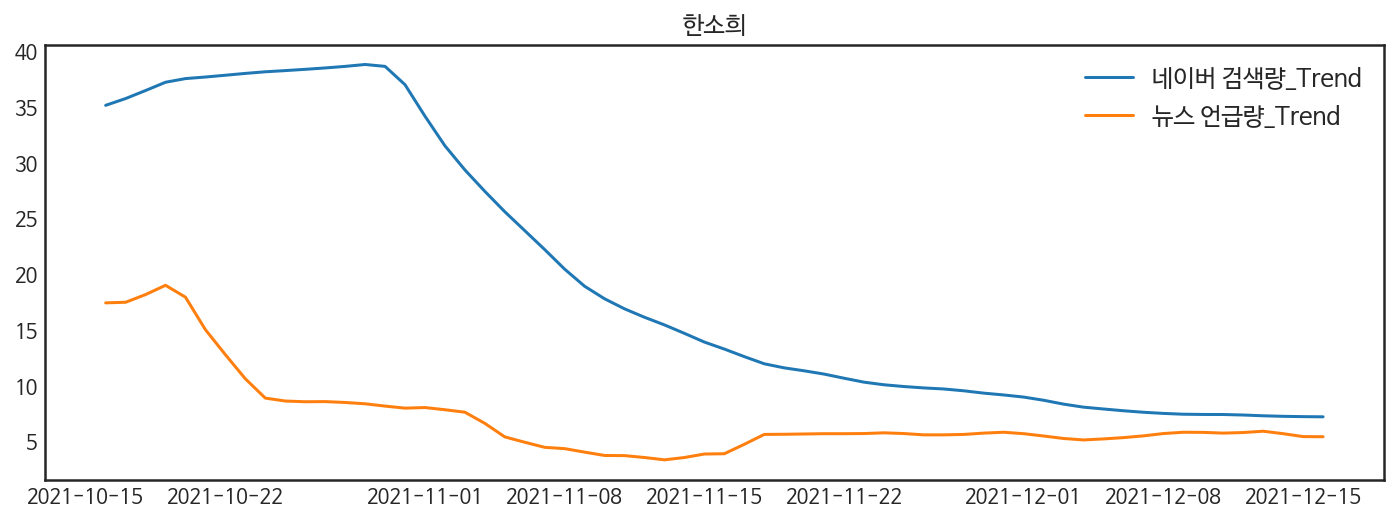

In [52]:
plt.figure(figsize=(12,4))
plt.plot(df_검색량_decomposition.trend, label='네이버 검색량_Trend')
plt.plot(decompostion_ratio.trend, label='뉴스 언급량_Trend')
plt.title(keyword)
plt.legend(fontsize=12)
plt.show()

### 키워드간 뉴스 언급량 비교

In [53]:
# keywords = list(input().split(' '))

for keyword in keywords :
  globals()['df_time_{}'.format(keyword)] = df[['일자','noun']]
  globals()['df_time_{}'.format(keyword)]['count'] = globals()['df_time_{}'.format(keyword)]['noun'].apply(lambda x : 1 if keyword in x else 0)
  globals()['df_time_{}'.format(keyword)] = globals()['df_time_{}'.format(keyword)].groupby('일자').sum()
  if globals()['df_time_{}'.format(keyword)]['count'].sum() == 0 :
    globals()['df_time_{}'.format(keyword)]['ratio'] = 0
  else :
    globals()['df_time_{}'.format(keyword)]['ratio'] = globals()['df_time_{}'.format(keyword)]['count'] / globals()['df_time_{}'.format(keyword)]['count'].sum() *100

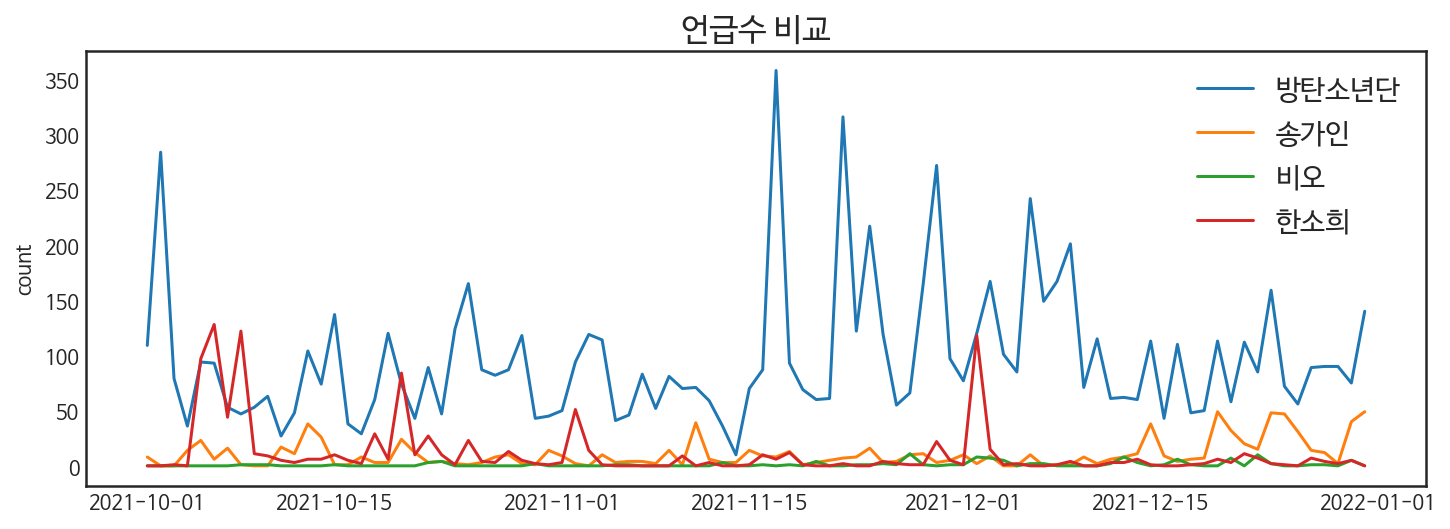

In [54]:
fig = plt.figure(figsize=(12,4))
for keyword in keywords :
  plt.plot(globals()['df_time_{}'.format(keyword)]['count'], label=keyword)
  plt.title('언급수 비교', fontsize=16)
  plt.legend(fontsize=14)
  plt.ylabel('count')
plt.show()

In [55]:
for keyword in keywords :
  globals()['decompostion_{}'.format(keyword)] = sm.tsa.seasonal_decompose(globals()['df_time_{}'.format(keyword)]['count'], model='additive', period=30)   # model{“additive”, “multiplicative”}

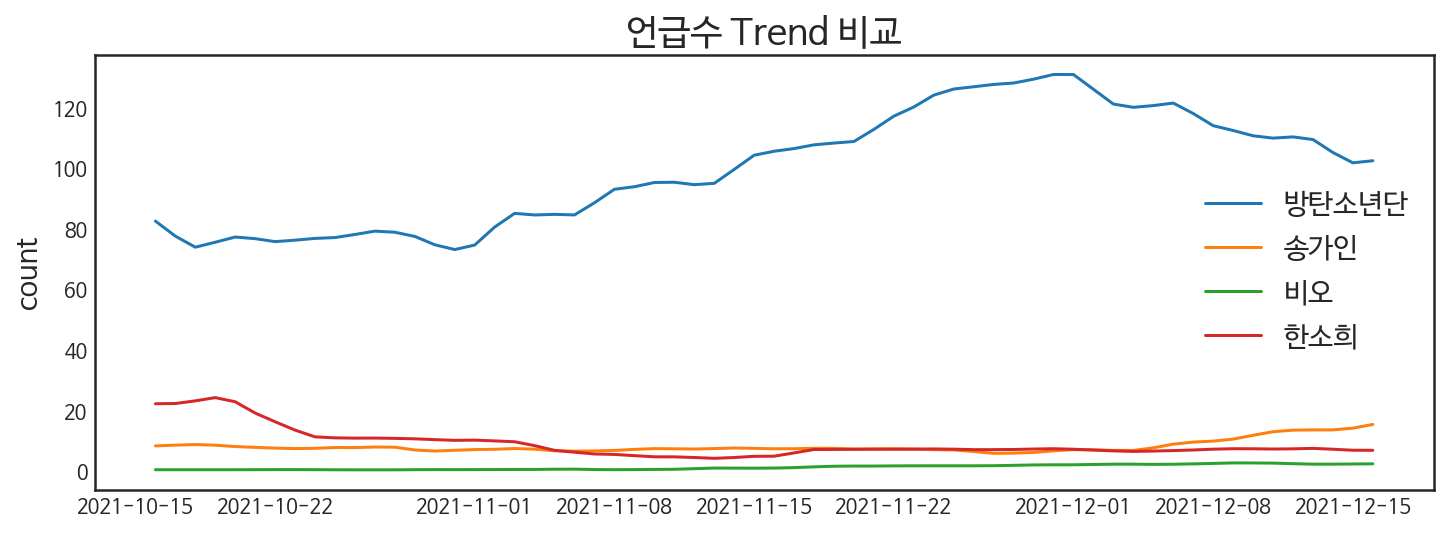

In [56]:
fig = plt.figure(figsize=(12,4))
for keyword in keywords :
  plt.plot(globals()['decompostion_{}'.format(keyword)].trend, label=keyword)
  plt.title('언급수 Trend 비교', fontsize=18)
  plt.legend(fontsize=14)
  plt.ylabel('count', fontsize=14)
plt.show()

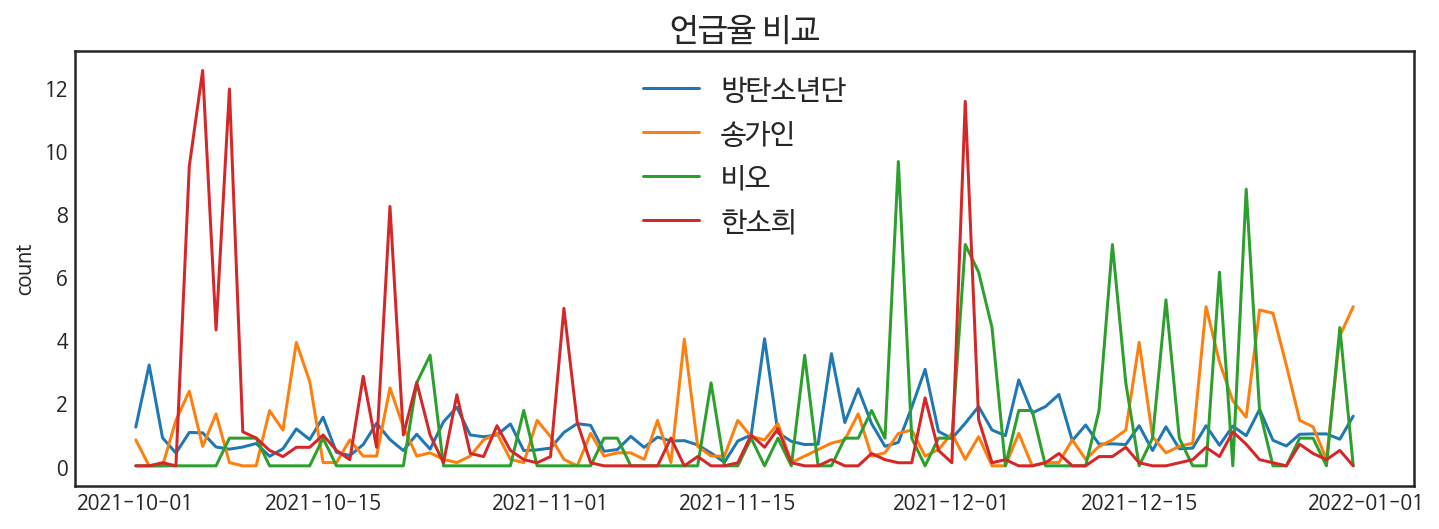

In [57]:
fig = plt.figure(figsize=(12,4))
for keyword in keywords :
  plt.plot(globals()['df_time_{}'.format(keyword)]['ratio'], label=keyword)
  plt.title('언급율 비교', fontsize=16)
  plt.legend(fontsize=14)
  plt.ylabel('count')
plt.show()

In [58]:
for keyword in keywords :
  globals()['decompostion_{}'.format(keyword)] = sm.tsa.seasonal_decompose(globals()['df_time_{}'.format(keyword)]['ratio'], model='additive', period=30)   # model{“additive”, “multiplicative”}

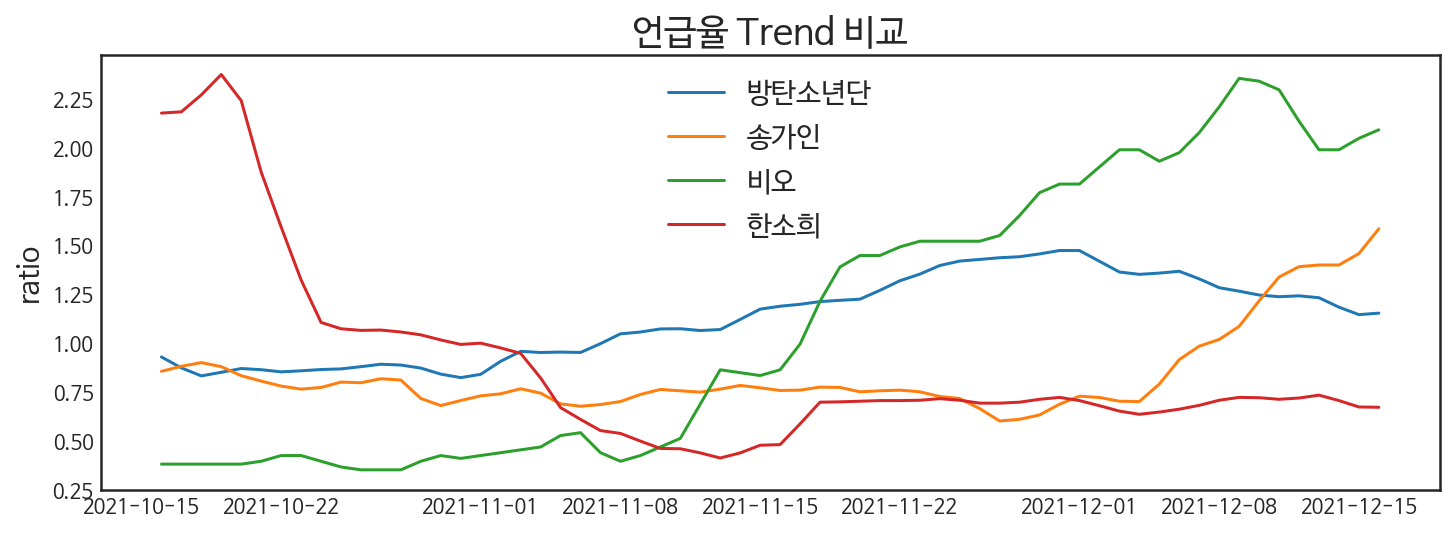

In [59]:
fig = plt.figure(figsize=(12,4))
for keyword in keywords :
  plt.plot(globals()['decompostion_{}'.format(keyword)].trend, label=keyword)
  plt.title('언급율 Trend 비교', fontsize=18)
  plt.legend(fontsize=14)
  plt.ylabel('ratio', fontsize=14)
plt.show()

# **결론**

## 연예인 리스트

In [60]:
name = pd.read_excel(r'/content/drive/MyDrive/3조_final_project/02_연예 뉴스/name_freq.xlsx')
name['bigram_20'] = name['연예인 이름'].apply(lambda x : cfd[x].most_common(20))
name['trigram_20'] = name['연예인 이름'].apply(lambda x : cfd_trigrams[x].most_common(20))
name['w2v_20'] = name['연예인 이름'].apply(lambda x : w2v.wv.most_similar(x, topn=20) if x in w2v.wv.vocab.keys() else ' ')

In [61]:
print(name.shape)
print(name.info())
name.head()

(1097, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   번호          1097 non-null   int64 
 1   연예인 이름      1097 non-null   object
 2   빈도수         1097 non-null   int64 
 3   bigram_20   1097 non-null   object
 4   trigram_20  1097 non-null   object
 5   w2v_20      1097 non-null   object
dtypes: int64(2), object(4)
memory usage: 51.5+ KB
None


,번호,연예인 이름,빈도수,bigram_20,trigram_20,w2v_20
0,1,방탄소년단,9279,"[(뷔, 1022), (지민, 804), (정국, 694), (콜드플레이, 338)...","[((콜드플레이, 마이), 109), ((콜드플레이, 협업곡), 83), ((콜드플...","[(JIMTOBER, 0.7522742748260498), (강양이, 0.72932..."
1,2,임영웅,4704,"[(도망, 333), (유튜브, 182), (단독쇼, 164), (멜론, 129),...","[((아이돌, 평점랭킹), 66), ((도망, 유튜브), 58), ((도망, 멜론)...","[(단독쇼, 0.7896051406860352), (HERO, 0.758446216..."
2,3,유재석,2612,"[(미주, 205), (코로나, 138), (안테나, 83), (유희열, 67), ...","[((코로나, 확진), 60), ((코로나, 완치), 46), ((MBC, 연예대상...","[(놀면뭐하니, 0.9200135469436646), (놀뭐, 0.909241318..."
3,4,에스파,2555,"[(카리나, 297), (윈터, 221), (지젤, 158), (새비지, 148),...","[((미니앨범, SAVAGE), 38), ((넥스트, 레벨), 30), ((카리나,...","[(카리나, 0.8533837795257568), (지젤, 0.83872747421..."
4,5,아이브,2462,"[(원영, 228), (장원영, 216), (유진, 166), (IVE, 143),...","[((장원영, 안유진), 35), ((IVE, 원영), 28), ((이서, 막내),...","[(IVE, 0.9072157144546509), (조혁진, 0.8730868101..."


In [62]:
name['bigram_20'] = name['bigram_20'].astype(str)
name['trigram_20'] = name['trigram_20'].astype(str)
name['w2v_20'] = name['w2v_20'].astype(str)

In [146]:
topic = '환경'
name[(name['bigram_20'].str.contains(topic)) | (name['trigram_20'].str.contains(topic)) | (name['trigram_20'].str.contains(topic))]

,번호,연예인 이름,빈도수,bigram_20,trigram_20,w2v_20
55,56,공효진,910,"[('이천희', 190), ('전혜진', 40), ('최준', 30), ('엄지원'...","[(('이천희', '전혜진'), 180), (('전혜진', '이천희'), 12), ...","[('무해', 0.9713323712348938), ('뜯어고쳤나', 0.94890..."
230,231,전혜진,423,"[('이천희', 32), ('이경훈', 26), ('이상우', 19), ('탄소제로...","[(('탄소', '제로'), 11), (('KBS', '뉴스'), 7), (('민낯...","[('이천희', 0.9727262258529663), ('무해', 0.9620309..."
388,389,이천희,288,"[('전혜진', 256), ('공효진', 11), ('탄소제로', 4), ('년지기...","[(('전혜진', '죽도'), 11), (('전혜진', '무해'), 11), (('...","[('무해', 0.9833993911743164), ('오늘무해', 0.980969..."
904,905,박서진,126,"[('흥한자', 14), ('국가대표', 7), ('가이드', 6), ('친환경',...","[(('국가대표', '와이프'), 7), (('친환경', '농산물'), 4), ((...","[('흥한자', 0.9698845148086548), ('경쾌', 0.9377522..."
1068,1069,버나드,103,"[('BAD', 21), ('배드', 10), ('어나운스먼트', 6), ('박진영...","[(('BAD', 'INFLUENCE'), 21), (('배드', '인플루언스'),...","[('BAD', 0.9377310276031494), ('개인별', 0.932960..."


## 트렌드 관련 검색어

In [64]:
trend_word = pd.read_csv(r'/content/drive/MyDrive/3조_final_project/02_연예 뉴스/연예 뉴스 키워드 추출.txt', sep='\n', header=None)

In [65]:
trend_word.columns = ['검색어']
print(len(trend_word.검색어.unique()))
print(trend_word.검색어.unique())

49
['코로나' '설강화' '스우파' '지혜중' '콘서트' '로맨스' '아이돌' '놀면뭐하니' '에스파' '케미' '카리스마' '케이팝'
 '신사와아가씨' '알고있지만' '갯마을' '옷소매' '안다행' '검은태양' '달리와감자탕' '멜랑꼴리아' '골때녀' '쇼윈도'
 '이방원' '런닝맨' '연모' '갓파더' '경관' '불가살' '고요' '예능' '드라마' '대상' '꽃피면' '방과후' '맘마미안'
 '패션' '데이트' '글로벌' '크리스마스' '포스터' '훈훈' '섹시' '솔로' '오징어' '지리산' '여신' '원더우먼'
 '애로부부' '쇼미더머니']


In [66]:
trend_word = trend_word[(trend_word['검색어'] == '훈훈') | (trend_word['검색어'] == '원더우먼')]

In [67]:
trend_word

,검색어
40,훈훈
47,원더우먼


In [68]:
trend_df = pd.DataFrame(columns=['검색어', '연예인 이름', '빈도수', 'bigram_20', 'trigram_20', 'w2v_20'])
trend_df

,검색어,연예인 이름,빈도수,bigram_20,trigram_20,w2v_20


In [69]:
idx = 0
for word in trend_word['검색어'] :
  a = len(name[(name['bigram_20'].str.contains(word)) | (name['trigram_20'].str.contains(word)) | (name['trigram_20'].str.contains(word))])

  if a == 0 :
    trend_df.loc[idx, '검색어'] = word
    trend_df.loc[idx, 1:] = ' '
    idx += 1
  else :
    for i in range(a) :
      trend_df.loc[idx+i, '검색어'] = word
      trend_df.loc[idx+i, 1:] = name[(name['bigram_20'].str.contains(word)) | (name['trigram_20'].str.contains(word)) | (name['trigram_20'].str.contains(word))].iloc[i,1:]
    idx += a

In [70]:
trend_df

,검색어,연예인 이름,빈도수,bigram_20,trigram_20,w2v_20
0,훈훈,이준호,1726,"[('이세영', 799), ('옷소매', 56), ('MBC', 23), ('임윤아...","[(('이세영', '옷소매'), 66), (('이세영', '강훈'), 23), ((...","[('옷소매', 0.9425305128097534), ('홍섭녀', 0.920538..."
1,훈훈,정동원,1618,"[('콘서트', 56), ('그리움', 53), ('크리스마스', 32), ('정규...","[(('그리움', '없이'), 49), (('크리스마스', '콘서트'), 22), ...","[('미스터트롯', 0.8188221454620361), ('쏭닥터', 0.7949..."
2,훈훈,이승기,986,"[('이다인', 70), ('카이', 46), ('싱어게인', 37), ('장도연'...","[(('장도연', '한혜진'), 22), (('골든디스크', '어워즈'), 13),...","[('슬로', 0.844249427318573), ('슈퍼노트', 0.8056820..."
3,훈훈,이도현,934,"[('임수정', 112), ('수학', 67), ('멜랑꼴리아', 47), ('진경...","[(('수학', '천재'), 16), (('김소현', '성시경'), 14), (('...","[('멜랑꼴리아', 0.9734424352645874), ('임수정', 0.9658..."
4,훈훈,김수현,915,"[('차승원', 199), ('김성규', 76), ('훈훈', 11), ('교도소'...","[(('차승원', '김성규'), 20), (('차승원', 'OST'), 12), (...","[('차승원', 0.8743777275085449), ('살인용의자', 0.8514..."
...,...,...,...,...,...,...
88,원더우먼,진서연,250,"[('이하늬', 31), ('이상윤', 13), ('복수', 9), ('정체', 8...","[(('이하늬', '정체'), 8), (('안효섭', '이솜'), 6), (('이상...","[('김봉만', 0.9633015394210815), ('박정화', 0.949471..."
89,원더우먼,송소희,181,"[('황소윤', 48), ('축구', 14), ('골때녀', 6), ('해트트릭',...","[(('축구', '전과'), 4), (('황소윤', '투톱'), 4), (('황소윤...","[('FC', 0.9771395325660706), ('탑걸', 0.97507059..."
90,원더우먼,이원근,134,"[('이하늬', 20), ('거절', 6), ('원더우먼', 5), ('공약', 5...","[(('거절', '이상윤'), 4), (('우월', '하루'), 4), (('OCN...","[('조연희', 0.9441018104553223), ('김봉만', 0.942317..."
91,원더우먼,박슬기,129,"[('소예', 23), ('악플', 8), ('골때녀', 7), ('FC원더우먼',...","[(('퉁퉁', '부은'), 4), (('악플', '너그럽게'), 3), (('FC...","[('아유미', 0.9563361406326294), ('박용근', 0.947658..."


## 공익광고 관련 검색어

In [71]:
ad_word = pd.read_excel(r'/content/drive/MyDrive/3조_final_project/02_연예 뉴스/공익광고 주제별 현황.xlsx')

In [72]:
print(len(ad_word.검색어) == len(ad_word.검색어.unique()))
print(len(ad_word.검색어.unique()))
print(ad_word.검색어.unique())

True
45
['청소년' '폭력' '가정' '가족' '국민' '나라' '부정' '부패' '선거' '절약' '소비' '경제' '통일' '국가'
 '보건' '위생' '헌혈' '담배' '마약' '나눔' '이웃' '화합' '타인' '배려' '매너' '안전' '휴대폰' '스마트폰'
 '공공' '질서' '예절' '장애인' '인터넷' '언어' '교통' '한강' '물' '재활용' '일회용품' '에너지' '불'
 '불조심' '산불' '환경' '보전']


In [73]:
ad_word = ad_word[(ad_word['검색어'] == '아동') | (ad_word['검색어'] == '가정')]

In [74]:
ad_word

,대분류,소분류,개수,비율,검색어
2,가정/청소년,가정/청소년,23,5.48926,가정


In [75]:
ad_df = pd.DataFrame(columns=['검색어', '연예인 이름', '빈도수', 'bigram_20', 'trigram_20', 'w2v_20'])
ad_df

,검색어,연예인 이름,빈도수,bigram_20,trigram_20,w2v_20


In [76]:
idx = 0
for word in ad_word['검색어'] :
  a = len(name[(name['bigram_20'].str.contains(word)) | (name['trigram_20'].str.contains(word)) | (name['trigram_20'].str.contains(word))])

  if a == 0 :
    ad_df.loc[idx, '검색어'] = word
    ad_df.loc[idx, 1:] = ' '
    idx += 1
  else :
    for i in range(a) :
      ad_df.loc[idx+i, '검색어'] = word
      ad_df.loc[idx+i, 1:] = name[(name['bigram_20'].str.contains(word)) | (name['trigram_20'].str.contains(word)) | (name['trigram_20'].str.contains(word))].iloc[i,1:]
    idx += a

In [77]:
ad_df

,검색어,연예인 이름,빈도수,bigram_20,trigram_20,w2v_20
0,가정,이세희,1075,"[('지현우', 133), ('박하나', 36), ('신사', 28), ('이태리'...","[(('신사', '아가씨'), 25), (('기습', '뽀뽀'), 14), (('핑...","[('지현우', 0.9789730310440063), ('박하나', 0.963878..."
1,가정,이시영,481,"[('북한산', 44), ('명품', 38), ('복지', 12), ('김해준', ...","[(('북한산', '등반'), 30), (('복지', '사각지대'), 12), ((...","[('외식사업가', 0.9240148663520813), ('북한산', 0.8946..."
2,가정,이성재,440,"[('전소민', 212), ('송윤아', 50), ('불륜', 24), ('키스',...","[(('전소민', '황찬성'), 25), (('전소민', '불륜'), 21), ((...","[('쇼윈', 0.9695737957954407), ('김해인', 0.9562268..."
3,가정,붐,377,"[('초아', 25), ('유나', 19), ('온주완', 18), ('토니안', ...","[(('유나', '키'), 19), (('토니안', '동거'), 10), (('장애...","[('김숙', 0.8234320282936096), ('끝내주는', 0.822791..."
4,가정,강예원,206,"[('박수영', 116), ('코로나', 30), ('안은진', 19), ('조이'...","[(('코로나', '확진'), 29), (('박수영', '워맨스'), 15), ((...","[('박수영', 0.9828227162361145), ('한사람', 0.972132..."
5,가정,이정현,172,"[('아기', 17), ('축하', 14), ('입덧', 11), ('설강화', 9...","[(('설강화', '정해인'), 7), (('최제헌', '정성호'), 6), (('...","[('입덧', 0.8919305801391602), ('서현진', 0.8778983..."
6,가정,강형욱,169,"[('훈련', 7), ('반려견', 7), ('대형견', 5), ('아기', 4),...","[(('프로', '듀서'), 4), (('대형견', '입마개'), 3), (('식탐...","[('보호자', 0.9535606503486633), ('견', 0.95317757..."
7,가정,고원희,153,"[('임현주', 45), ('백수세끼', 13), ('넷플릭스', 9), ('하석진...","[(('넷플릭스', '대전'), 5), (('곱창', '인분'), 5), (('임현...","[('임현주', 0.9633691906929016), ('백수세끼', 0.96160..."
8,가정,장혜진,135,"[('김세정', 33), ('RE', 8), ('우아', 8), ('발라드', 4)...","[(('RE', 'MAIN'), 8), (('김세정', '내게로'), 6), (('...","[('내게로', 0.938162088394165), ('음색퀸', 0.8847684..."
9,가정,신성,133,"[('김혜영과', 8), ('가습기', 5), ('황윤성', 5), ('봄날', 4...","[(('가습기', '보이스'), 5), (('시', '내고향'), 3), (('맛있...","[('김혜영과', 0.916850209236145), ('맛있었다', 0.88746..."


## 연예인 업급량 추세 분석

In [130]:
tot = pd.merge(left=trend_df, right=ad_df, how="inner", on="연예인 이름")
tot = tot[['연예인 이름', '검색어_x', '검색어_y', '빈도수_x', 'bigram_20_x', 'trigram_20_x', 'w2v_20_x']]
tot.columns = ['연예인 이름', '트렌드 검색어', '공익광고 검색어','뉴스 빈도수', 'bigram_20', 'trigram_20', 'w2v_20']

In [131]:
tot

,연예인 이름,트렌드 검색어,공익광고 검색어,뉴스 빈도수,bigram_20,trigram_20,w2v_20
0,이시영,훈훈,가정,481,"[('북한산', 44), ('명품', 38), ('복지', 12), ('김해준', ...","[(('북한산', '등반'), 30), (('복지', '사각지대'), 12), ((...","[('외식사업가', 0.9240148663520813), ('북한산', 0.8946..."
1,장혜진,훈훈,가정,135,"[('김세정', 33), ('RE', 8), ('우아', 8), ('발라드', 4)...","[(('RE', 'MAIN'), 8), (('김세정', '내게로'), 6), (('...","[('내게로', 0.938162088394165), ('음색퀸', 0.8847684..."


In [144]:
topic = '환경'
a = name[(name['bigram_20'].str.contains(topic)) | (name['trigram_20'].str.contains(topic)) | (name['trigram_20'].str.contains(topic))]
a['연예인 이름'].tolist()

['공효진', '전혜진', '이천희', '박서진', '버나드']

In [133]:
# keywords = tot['연예인 이름'].tolist()
# keywords = ['윤계상', '김유정', '마동석', '유오성', '장혁', '진선규', '박지선', '표창원', '김성균']
keywords = ['제이홉','이상우']

In [134]:
# keywords = list(input().split(' '))

for keyword in keywords :
  globals()['df_time_{}'.format(keyword)] = df[['일자','noun']]
  globals()['df_time_{}'.format(keyword)]['count'] = globals()['df_time_{}'.format(keyword)]['noun'].apply(lambda x : 1 if keyword in x else 0)
  globals()['df_time_{}'.format(keyword)] = globals()['df_time_{}'.format(keyword)].groupby('일자').sum()
  if globals()['df_time_{}'.format(keyword)]['count'].sum() == 0 :
    globals()['df_time_{}'.format(keyword)]['ratio'] = 0
  else :
    globals()['df_time_{}'.format(keyword)]['ratio'] = globals()['df_time_{}'.format(keyword)]['count'] / globals()['df_time_{}'.format(keyword)]['count'].sum() *100

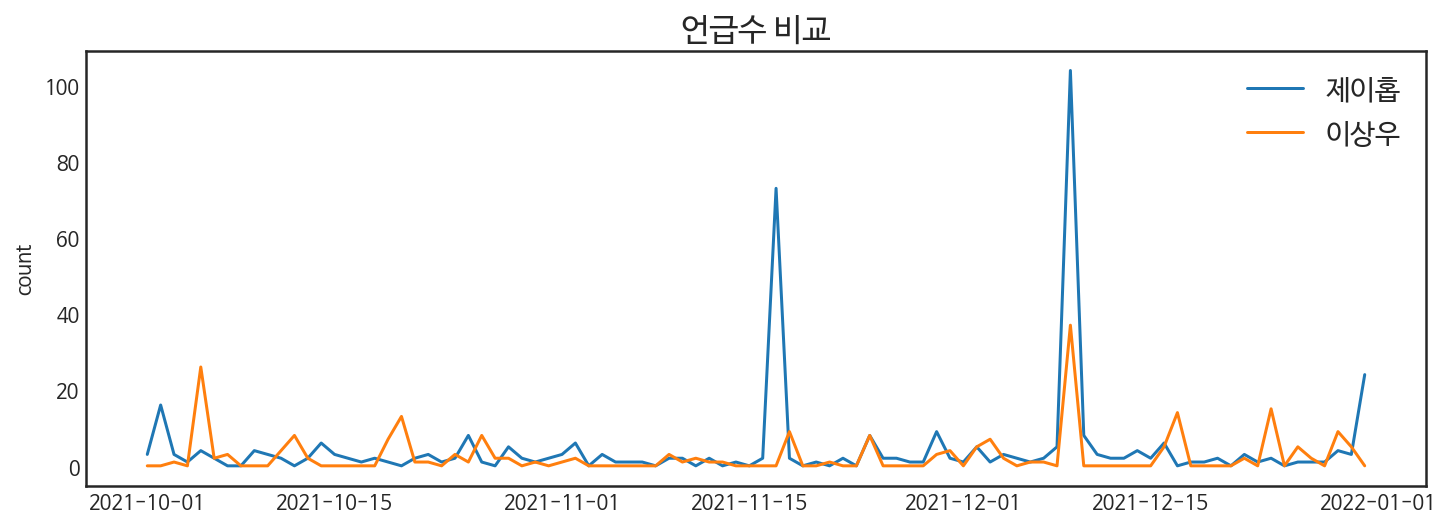

In [135]:
fig = plt.figure(figsize=(12,4))
for keyword in keywords :
  plt.plot(globals()['df_time_{}'.format(keyword)]['count'], label=keyword)
  plt.title('언급수 비교', fontsize=16)
  plt.legend(fontsize=14)
  plt.ylabel('count')
plt.show()

In [136]:
for keyword in keywords :
  globals()['decompostion_{}'.format(keyword)] = sm.tsa.seasonal_decompose(globals()['df_time_{}'.format(keyword)]['count'], model='additive', period=30)   # model{“additive”, “multiplicative”}

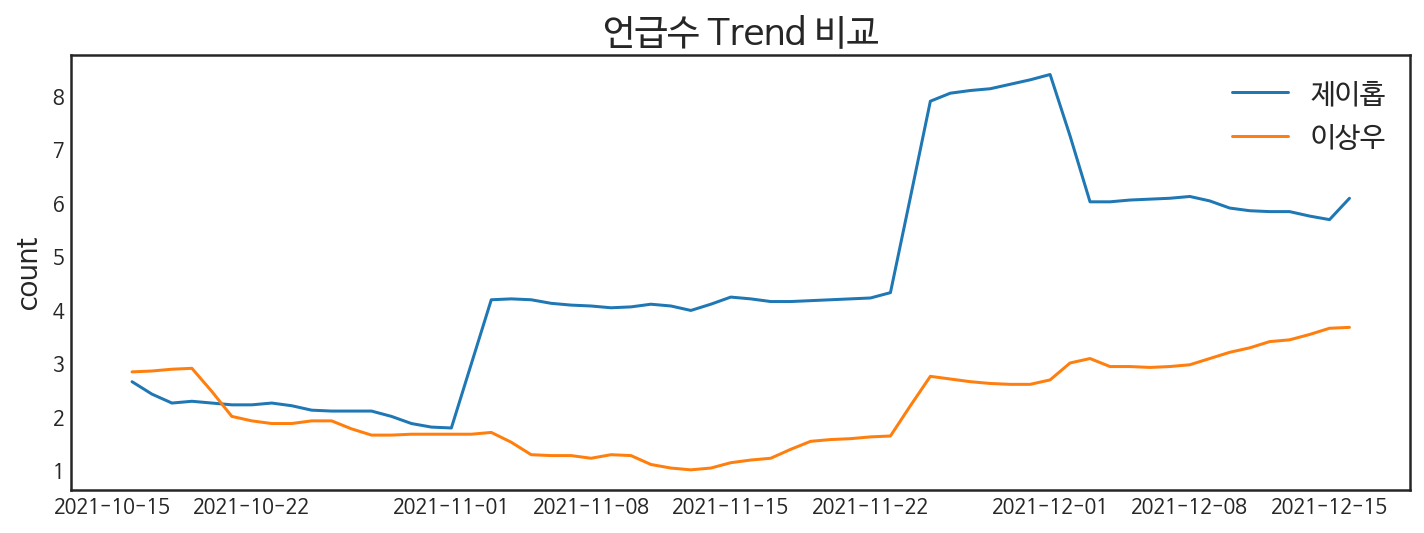

In [137]:
fig = plt.figure(figsize=(12,4))
for keyword in keywords :
  plt.plot(globals()['decompostion_{}'.format(keyword)].trend, label=keyword)
  plt.title('언급수 Trend 비교', fontsize=18)
  plt.legend(fontsize=14)
  plt.ylabel('count', fontsize=14)
plt.show()

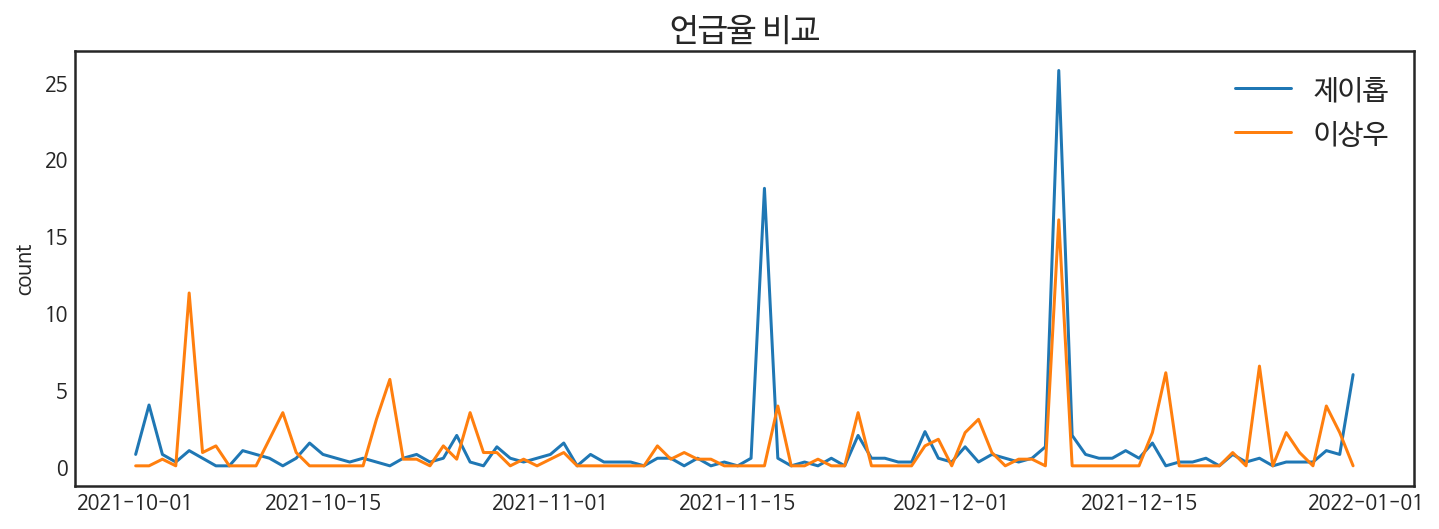

In [138]:
fig = plt.figure(figsize=(12,4))
for keyword in keywords :
  plt.plot(globals()['df_time_{}'.format(keyword)]['ratio'], label=keyword)
  plt.title('언급율 비교', fontsize=16)
  plt.legend(fontsize=14)
  plt.ylabel('count')
plt.show()

In [139]:
for keyword in keywords :
  globals()['decompostion_{}'.format(keyword)] = sm.tsa.seasonal_decompose(globals()['df_time_{}'.format(keyword)]['ratio'], model='additive', period=30)   # model{“additive”, “multiplicative”}

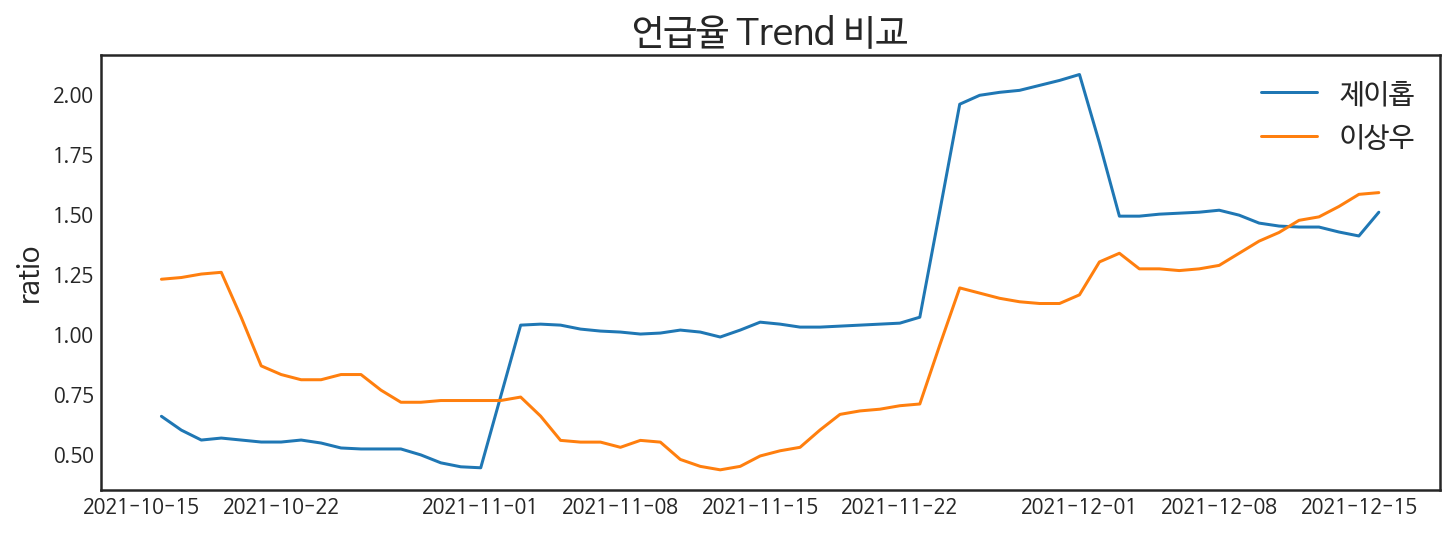

In [140]:
fig = plt.figure(figsize=(12,4))
for keyword in keywords :
  plt.plot(globals()['decompostion_{}'.format(keyword)].trend, label=keyword)
  plt.title('언급율 Trend 비교', fontsize=18)
  plt.legend(fontsize=14)
  plt.ylabel('ratio', fontsize=14)
plt.show()